## Analysis of AT2 organoids 7 days after in vitro KrasG12D induction

### Set up the environment

In [1]:
# Derived from https://scanpy.readthedocs.io/en/stable/tutorials.html

# Count matrices were generated using CellRanger Count (see 10X Genomics website)

# import packages 

import scanpy.external as sce
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
from seaborn import despine
from seaborn import axes_style
from matplotlib.pyplot import suptitle
import magic # imputation tool; van Dijk et al 2018 # 
import matplotlib.colors

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80) 

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


### Merge h5 files into a single anndata object

In [253]:
# CellRanger output
filenames = ['KY_empty_filtered_feature_bc_matrix.h5','KY_cre_filtered_feature_bc_matrix.h5']
adatas = [sc.read_10x_h5(filename) for filename in filenames]
adata = adatas[0].concatenate(adatas[1:],batch_categories=['KY-Empty','KY-Cre']) 

# make sure gene names are unique
adata.var_names_make_unique()

reading KY_empty_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading KY_cre_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Making variable names unique for controlled concatenation.


## Pre-processing the data

... storing 'feature_types' as categorical
... storing 'genome' as categorical


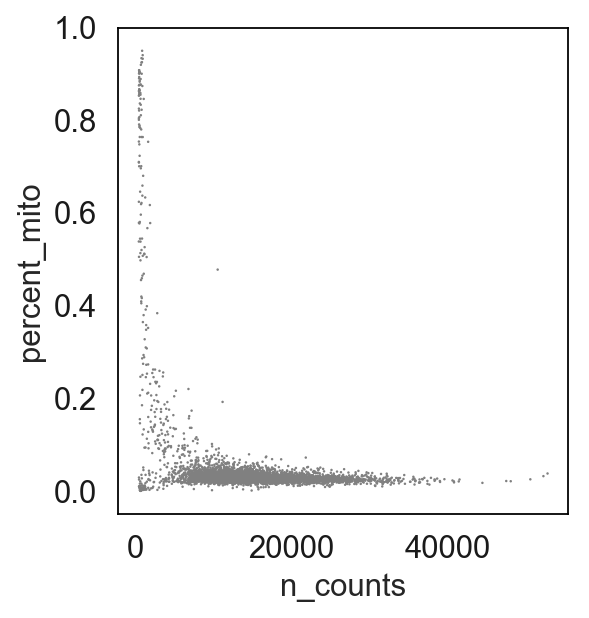

filtered out 11955 genes that are detectedin less than 3 cells


Trying to set attribute `.var` of view, making a copy.


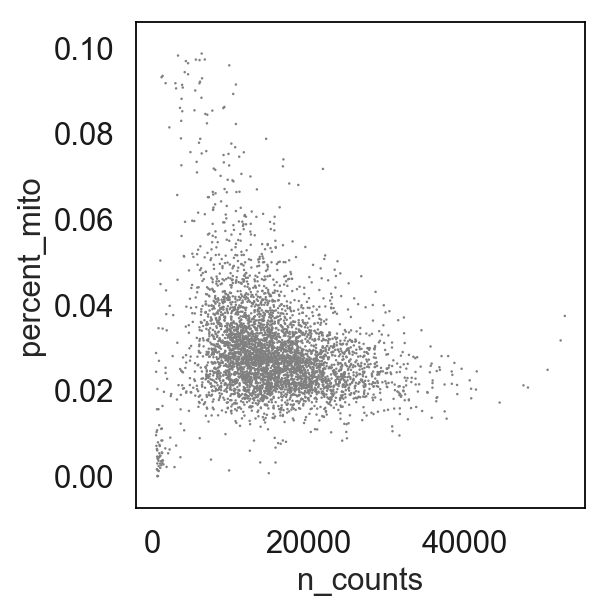

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 50
    finished (0:00:05)


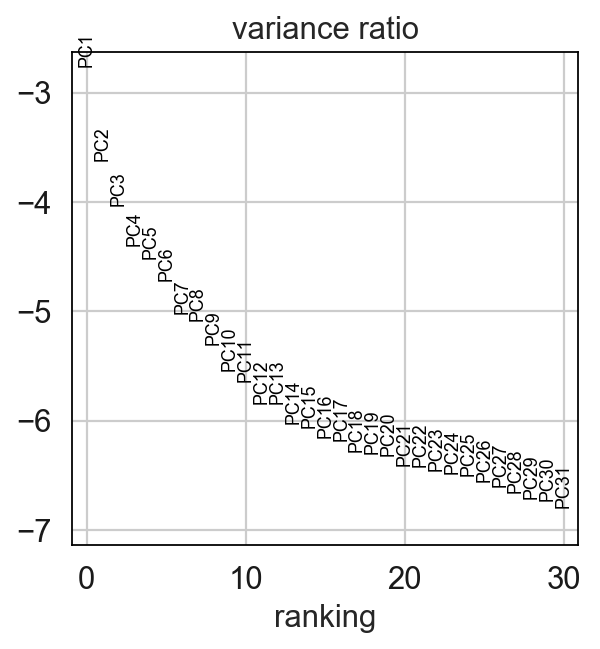

In [254]:
# compute %mito and remove cells with >10%
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

# plot mitochondrial content (y-axis) against read count before and after filtering cells with > 10% mitochondrial gene expression
# Cells wth >10% mito expression also has low read count indicating bad/dead cells rather than cells requiring more energy
sc.settings.set_figure_params(dpi=80)
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5, save='mito_counts_beforefiltering.png')

adata = adata[adata.obs['percent_mito'] < 0.1, :]
sc.pp.filter_genes(adata, min_cells=3)

with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5, save='mito_counts_afterfiltering.png')

# Normalize the data, save raw data, then use data diffusion tool (van Dijk et al 2018)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# No consensus about gene scaling so I did not scale the data. Read https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6582955/
# Not scaling argueably retains biological information
# I did not regress cell cycle either. A population of proliferative or non-proliferative cells in this context would be high interesting in my opinion

# save current data as adata.raw
adata.raw = adata

sc.tl.pca(adata, svd_solver='arpack') # svd_solver='arpack' is important for reproducibility
sc.pl.pca_variance_ratio(adata, log=True, save='pca_elbow.png') # find significant pc's

In [255]:
# Perform data diffusion. t=3 is sufficient to remove zero counts
# data diffusion tool is in scanpy.external 
sce.pp.magic(adata, name_list='all_genes', k=3, t=3, n_pca=30)

# code was run multiple times to produce Figure 4C

computing PHATE
    finished (0:00:04)


### Figure 4C

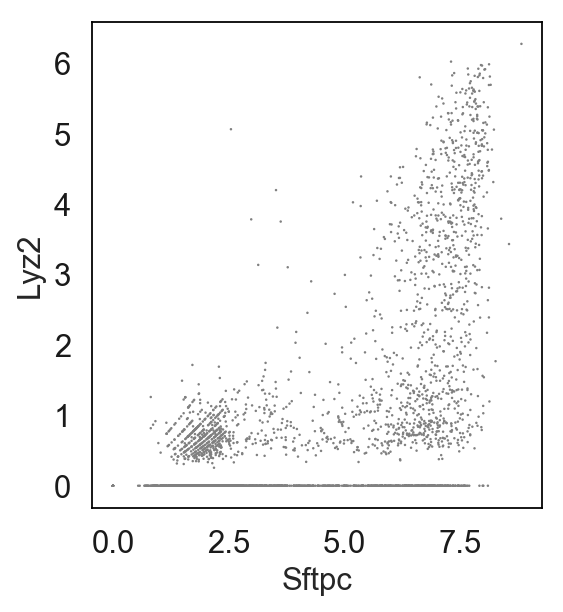

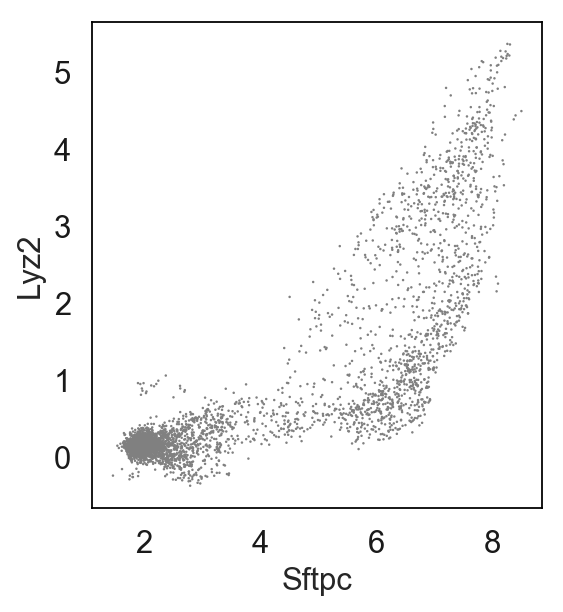

In [256]:
# Visualize

# Before MAGIC
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, x='Sftpc', y='Lyz2', size=5, use_raw=True, save='spc_lyz2_beforemagic.png')

# After MAGIC
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, x='Sftpc', y='Lyz2', size=5, use_raw=False, save='spc_lyz2_aftermagic.png')

In [257]:
#Intial filter
sc.pp.filter_cells(adata, min_genes=200)

# create nearest neighbors graph 
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)

# run louvain community detection algorithm
sc.tl.louvain(adata, resolution=0.01, key_added='louvain_r0.01')
sc.tl.louvain(adata, resolution=0.025, key_added='louvain_r0.025')
sc.tl.louvain(adata, resolution=0.05, key_added='louvain_r0.05')
sc.tl.louvain(adata, resolution=0.1, key_added='louvain_r0.1')
sc.tl.louvain(adata, resolution=0.2, key_added='louvain_r0.2')
sc.tl.louvain(adata, resolution=0.3, key_added='louvain_r0.3')
sc.tl.louvain(adata, resolution=0.4, key_added='louvain_r0.4')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

# Visualize different Louvain resolutions using UMAP
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
computing UMAP
    finished (0:00:03)


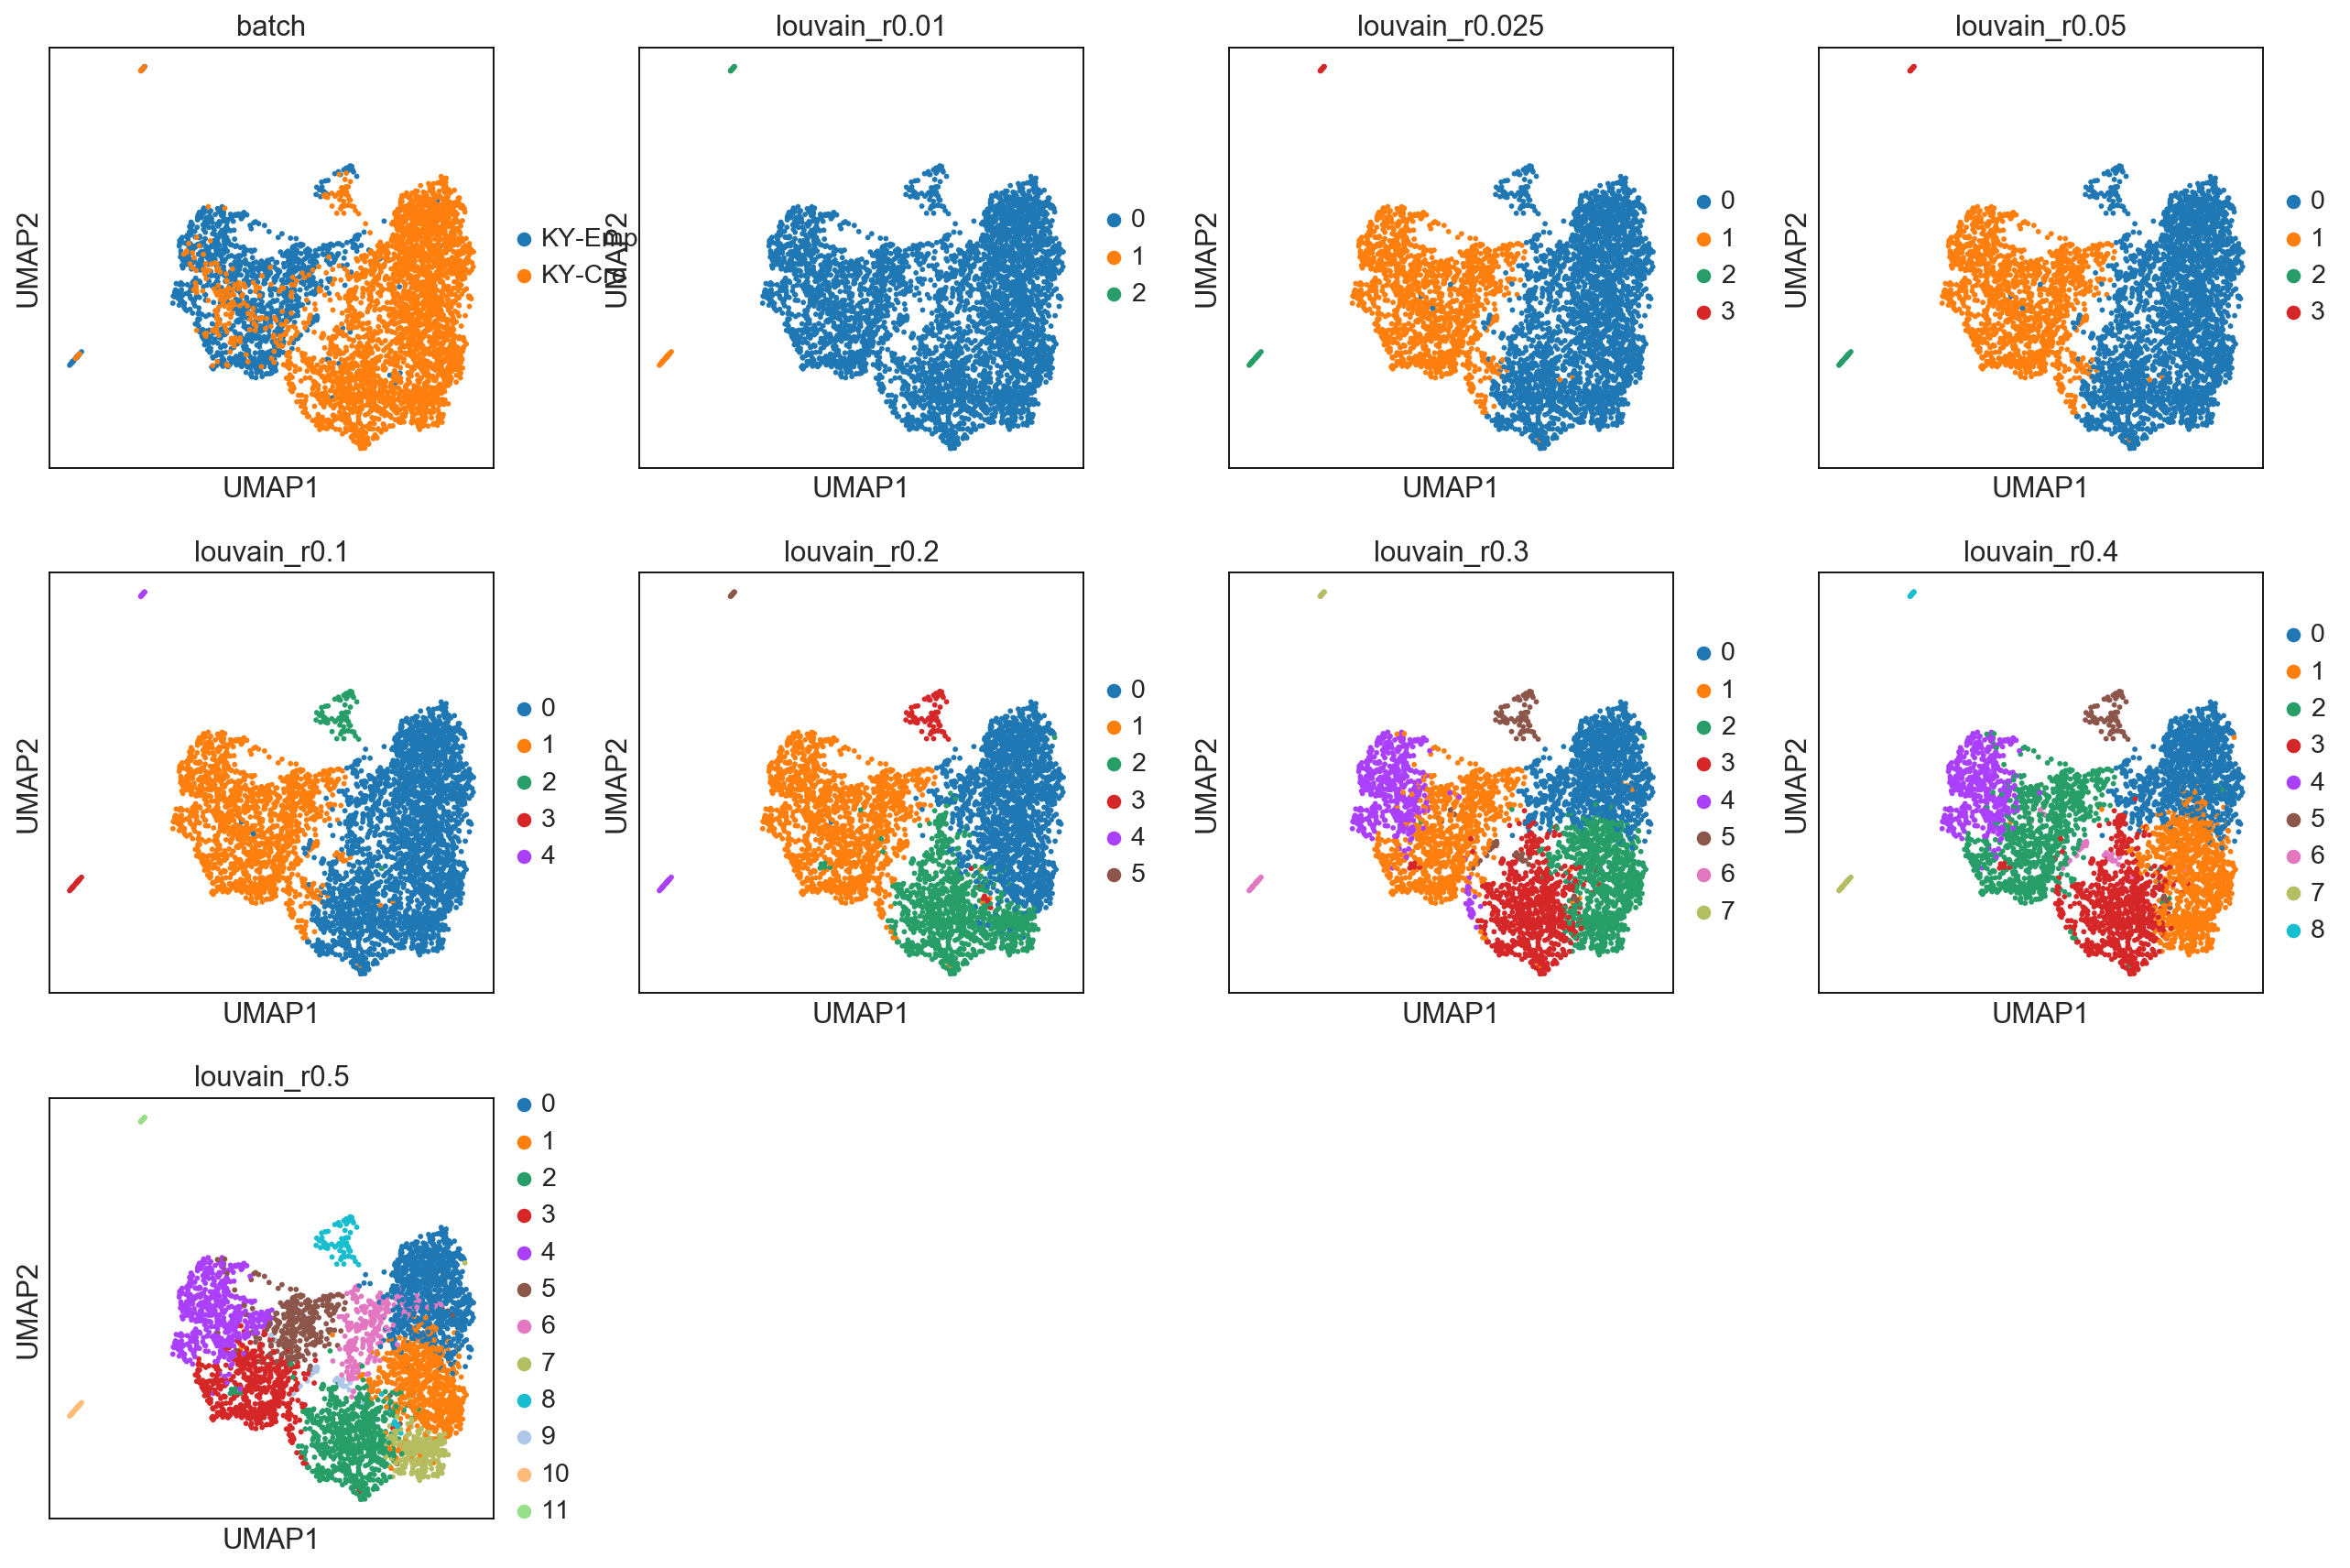

In [258]:
# Visualize
sc.pl.umap(adata, color=['batch','louvain_r0.01','louvain_r0.025','louvain_r0.05','louvain_r0.1','louvain_r0.2',
'louvain_r0.3','louvain_r0.4','louvain_r0.5'], save='_louvainclusters_differentresolutions.png')

running PAGA
    finished (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


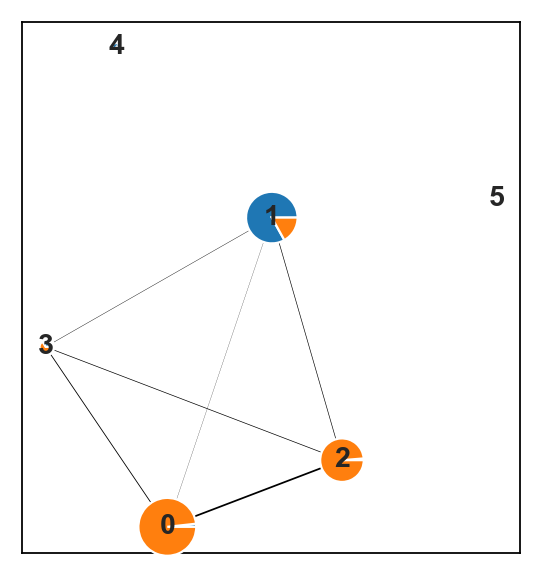

computing UMAP
    finished (0:00:03)


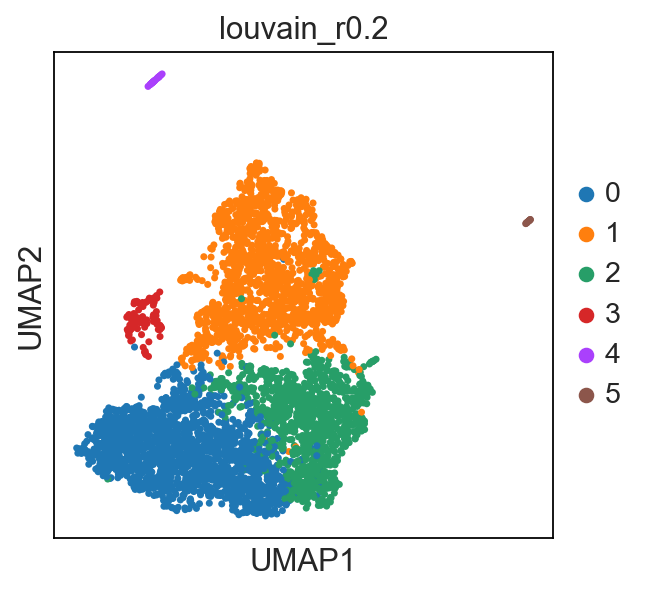

In [261]:
# Create a PAGA-initialized UMAP embedding (Wolf et al. 2018 Genome Biology). 
# Louvain_r0.2 was chosen based on signature gene expression

sc.tl.paga(adata, groups='louvain_r0.2')
sc.pl.paga(adata, plot=True, color=['batch'])

# sc.tl.umap(adata, init_pos='paga') is not working (August 7, 2019) https://github.com/theislab/scanpy/issues/769 = work around for now..

sc.tl.umap(adata, init_pos=sc.tl._utils.get_init_pos_from_paga(adata))
sc.pl.umap(adata, frameon=True, color=['louvain_r0.2'], legend_loc='right margin', size=40) # louvain

In [263]:
# counts cells per cluster then remove any clusters with less than 50 cells
adata.obs['louvain_r0.2'].value_counts()

0    1793
1    1425
2    1017
3      78
4      27
5      13
Name: louvain_r0.2, dtype: int64

In [271]:
# Remove small clusters and save subset data. Save adata too
adata_subset = adata[adata.obs['louvain_r0.2'].isin(['0','1','2'])]

### Figure 4B

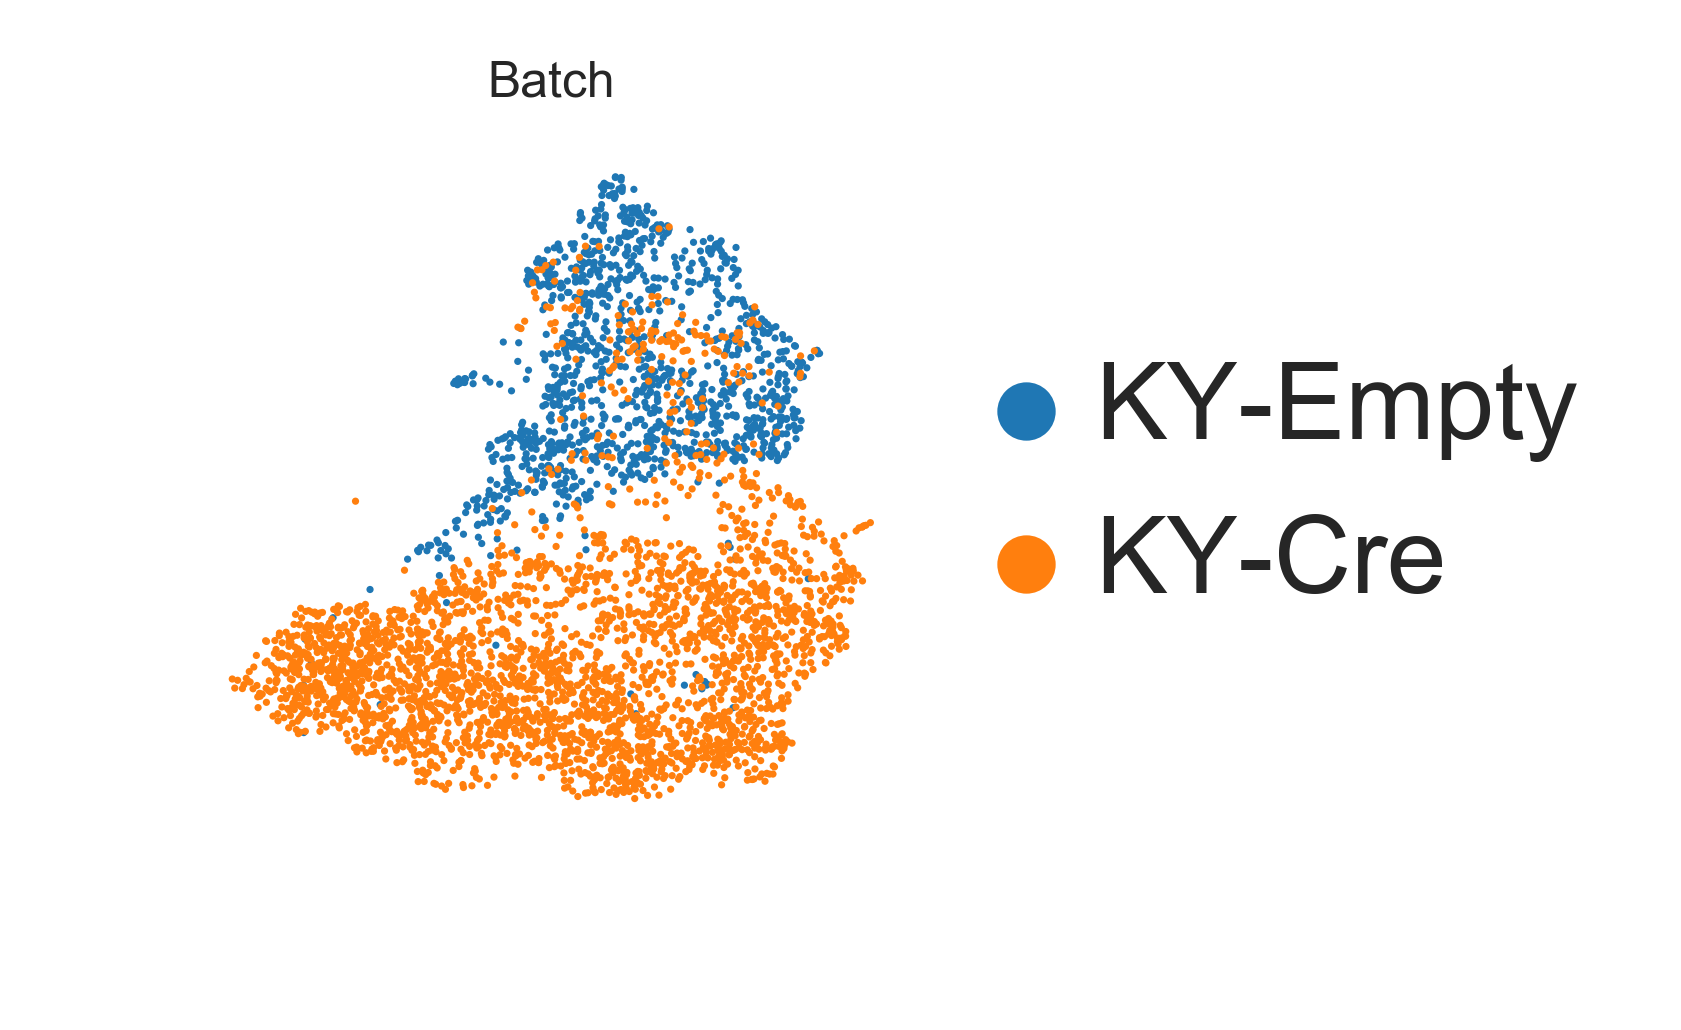

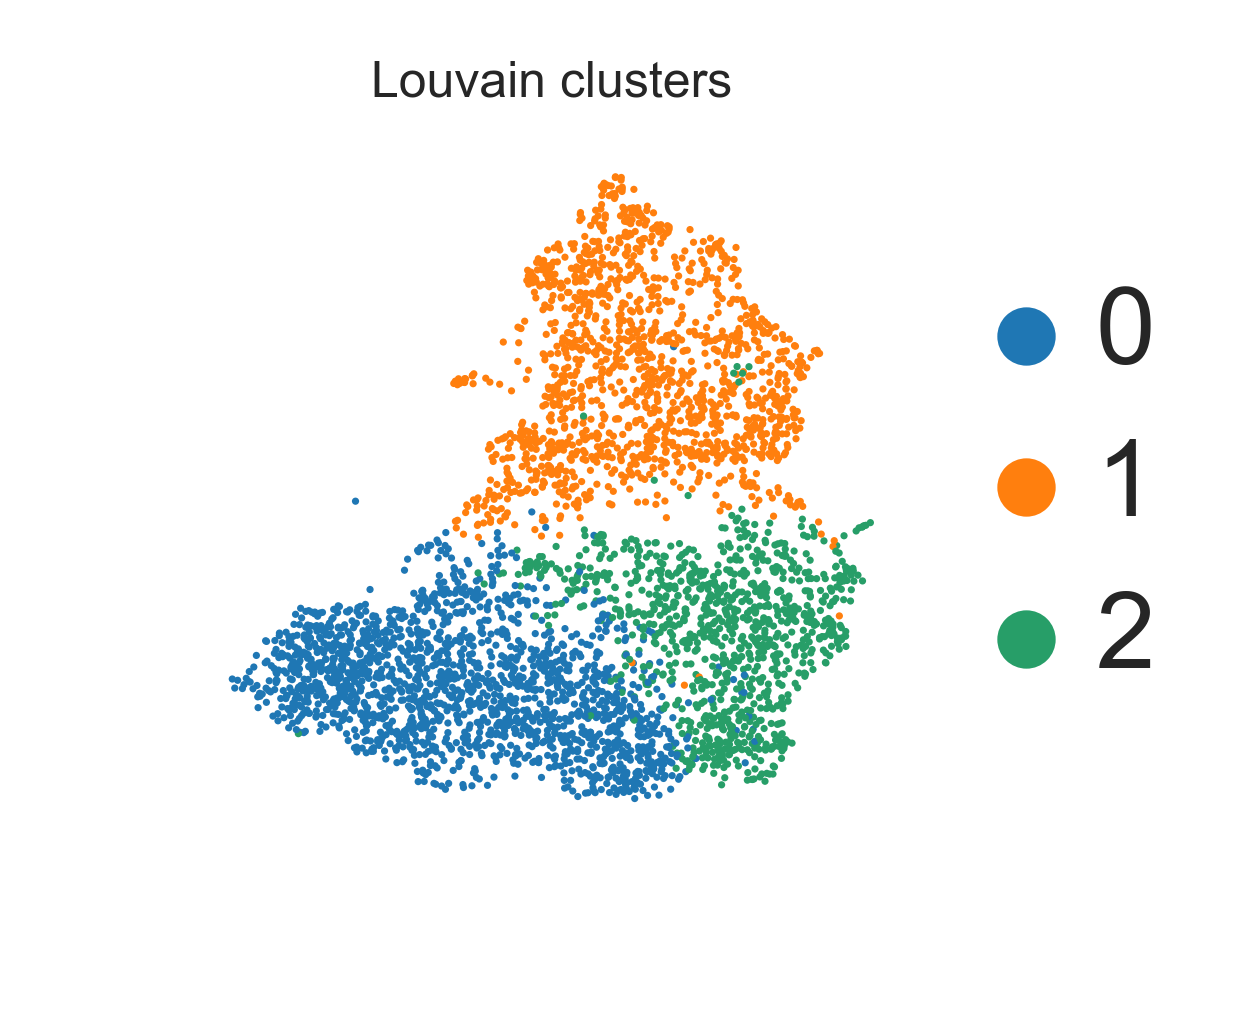

In [618]:
# Plot louvain and batch
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['blue','lightcoral','red']) 
use_raw='False'
frameon=False
size=3 
figsize=1.5,1.5
fontsize=6
dpi=300
tick_size=5 # https://github.com/theislab/scanpy/issues/337

rcParams['figure.figsize']=figsize
ax=sc.pl.umap(adata_subset, color=['batch'],  frameon=frameon, vmin=0, vmax=1, 
use_raw=use_raw, size=size, show=False)
plt.title('Batch', fontsize=fontsize)
ax.tick_params(labelsize=tick_size)
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
plt.savefig('./figures/umap_batch.png', bbox_inches='tight', dpi=dpi)

rcParams['figure.figsize']=figsize
ax=sc.pl.umap(adata_subset, color=['louvain_r0.2'],  frameon=frameon, vmin=0, vmax=1, 
use_raw=use_raw, size=size, show=False)
plt.title('Louvain clusters', fontsize=fontsize)
ax.tick_params(labelsize=tick_size)
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
plt.savefig('./figures/umap_louvain.png', bbox_inches='tight', dpi=dpi)

In [272]:
# Create a dendrogram/ Default = pearsons correlation coefficient
sc.tl.dendrogram(adata_subset, n_pcs=30, groupby='louvain_r0.2')

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_louvain_r0.2']`


### Figure S4E

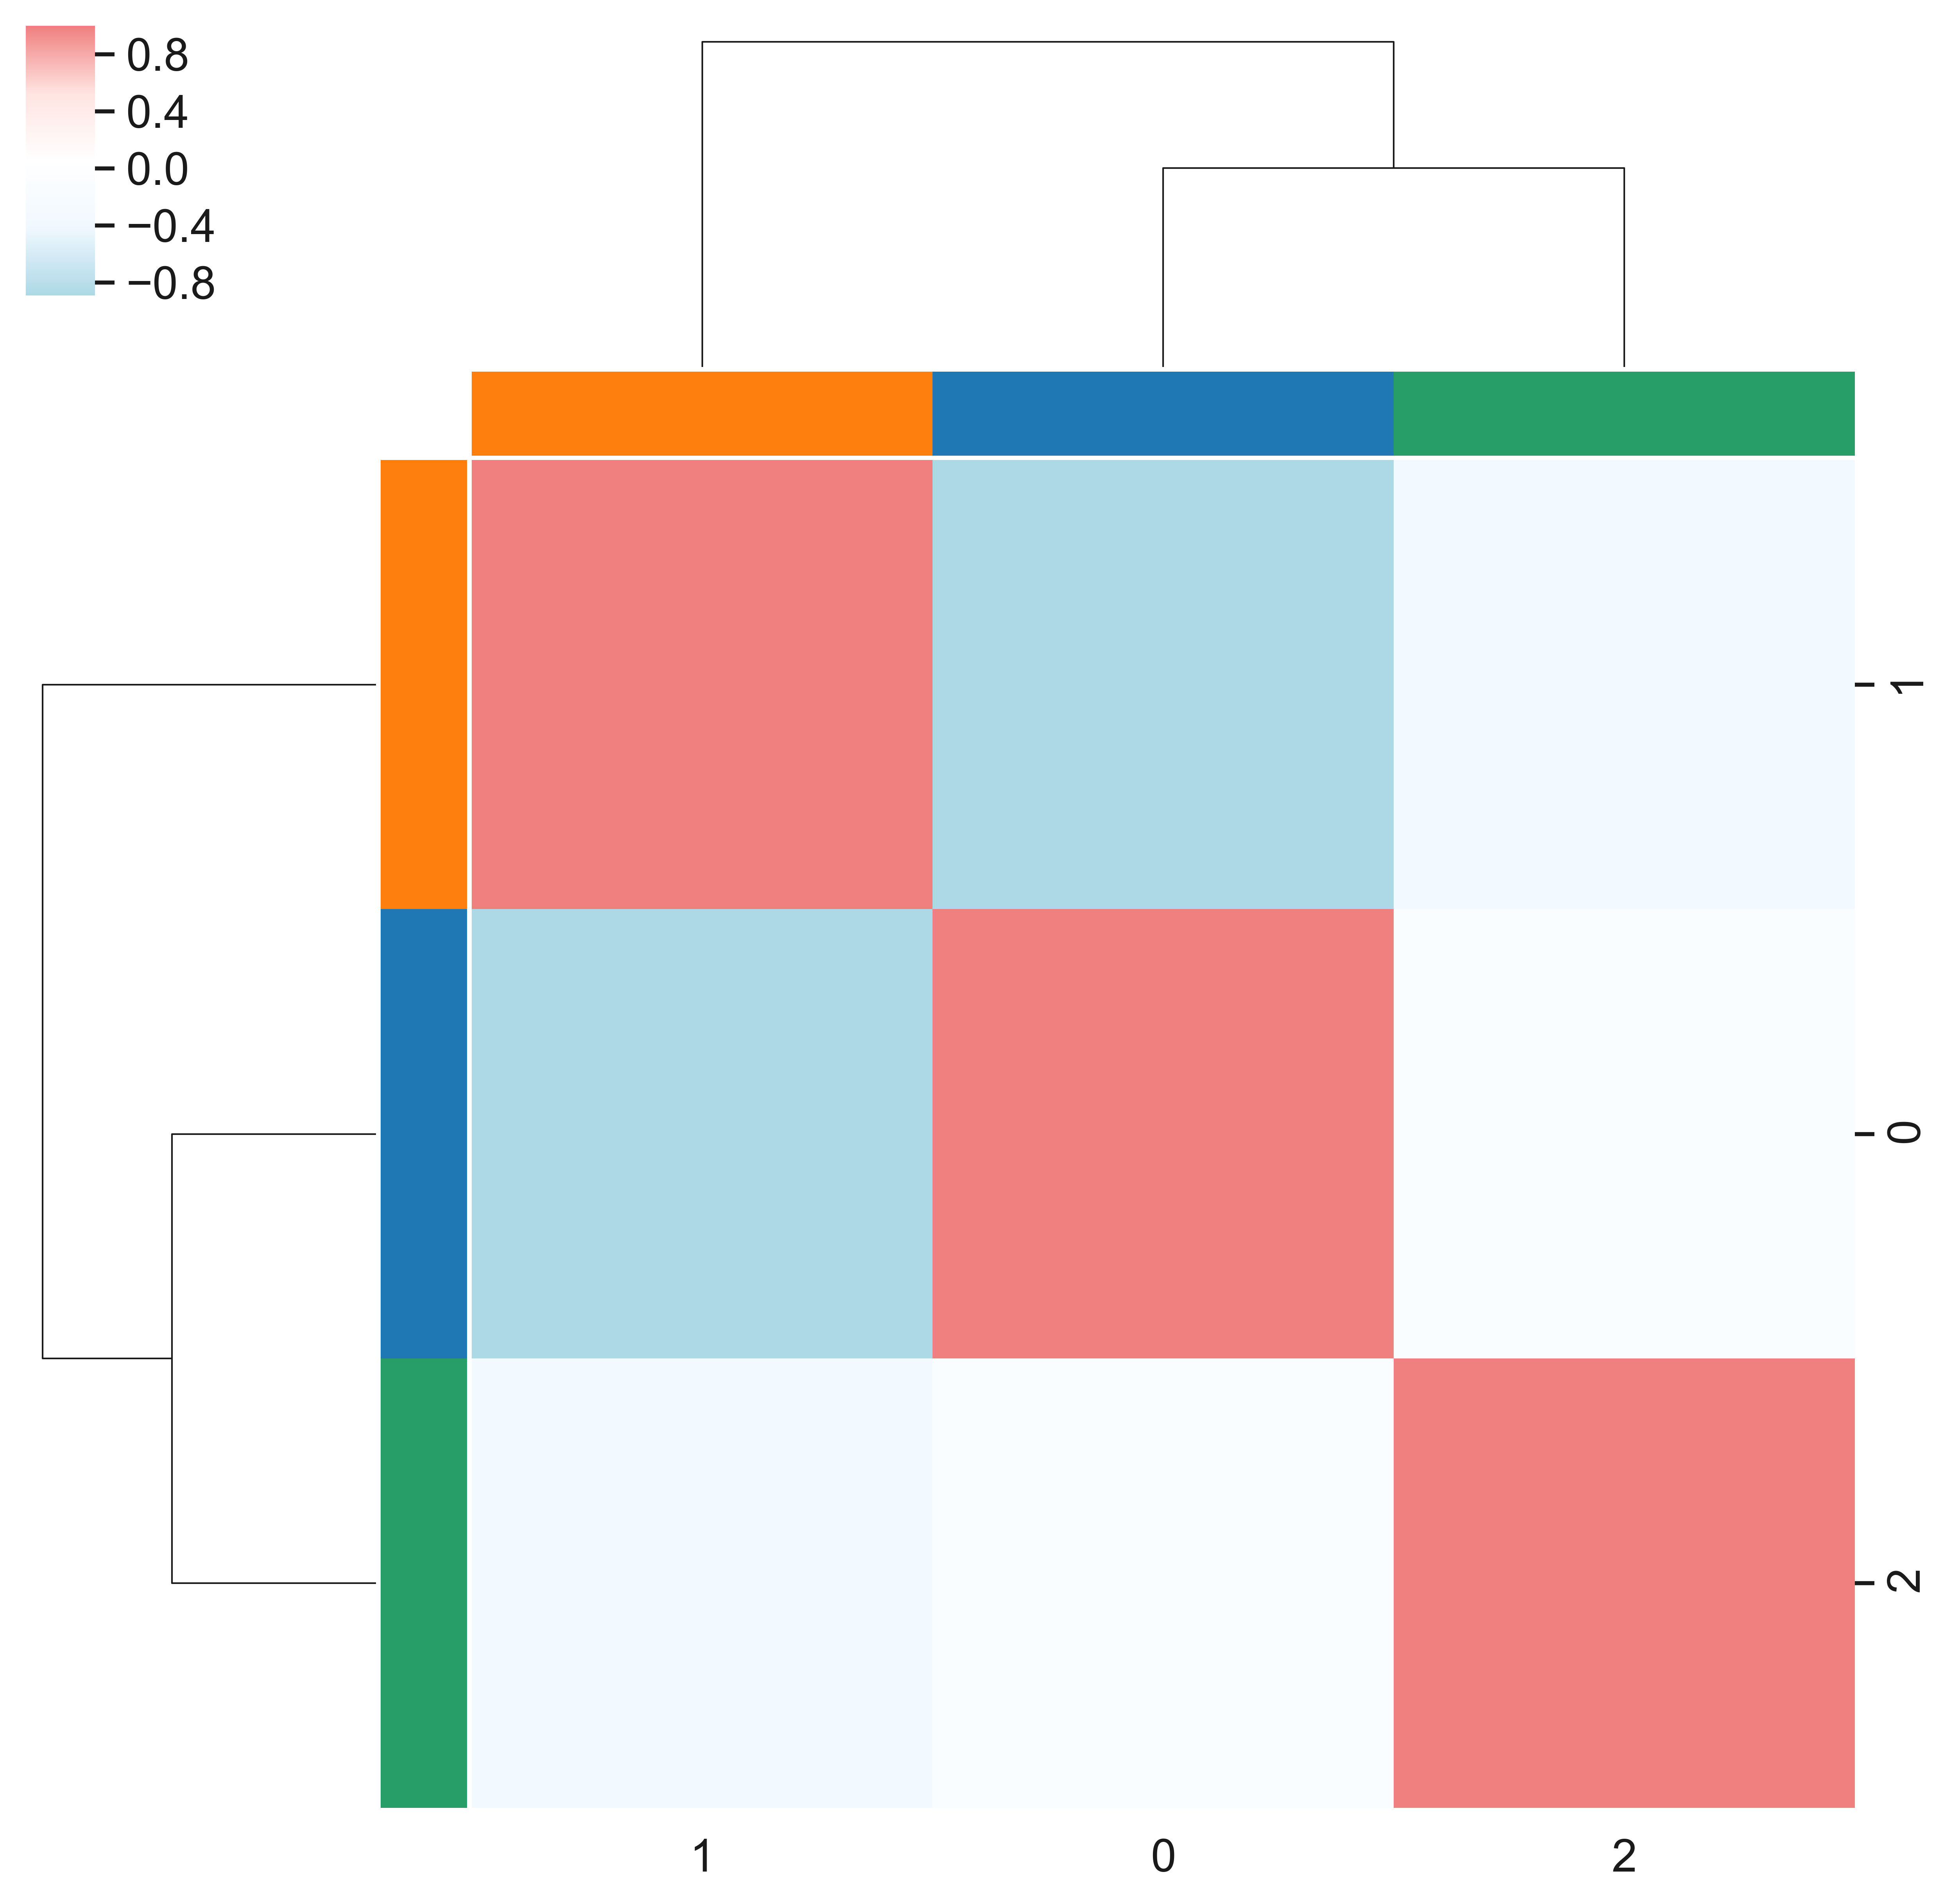

In [273]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightblue",'aliceblue','white','mistyrose',"lightcoral"]) 
g = sb.clustermap(
adata_subset.uns['dendrogram_louvain_r0.2']['correlation_matrix'],
row_linkage=adata_subset.uns['dendrogram_louvain_r0.2']['linkage'], 
col_linkage=adata_subset.uns['dendrogram_louvain_r0.2']['linkage'],
yticklabels=adata_subset.obs['louvain_r0.2'].cat.categories,
xticklabels=adata_subset.obs['louvain_r0.2'].cat.categories,
annot=False,
cmap=cmap,
row_colors=adata_subset.uns['louvain_r0.2_colors'],
col_colors=adata_subset.uns['louvain_r0.2_colors'],
cbar_kws={'label': ''}
                 )
plt.savefig('./figures/correlation_plot.png', bbox_inches='tight')

### Create an index column in adata_subset.obs for single cell calculations

In [ ]:
adata_subset.obs['index1'] = adata_subset.obs.index

## Plot epithelial marker genes

### Figure 4E

### Lyz2

In [596]:
# Add gene expression to adata.obs
adata_subset.obs['Lyz2']=adata_subset[:, ['Lyz2']].to_df()

# Find medians
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Lyz2', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.135796
1    1.777999
2    0.154078
dtype: float32

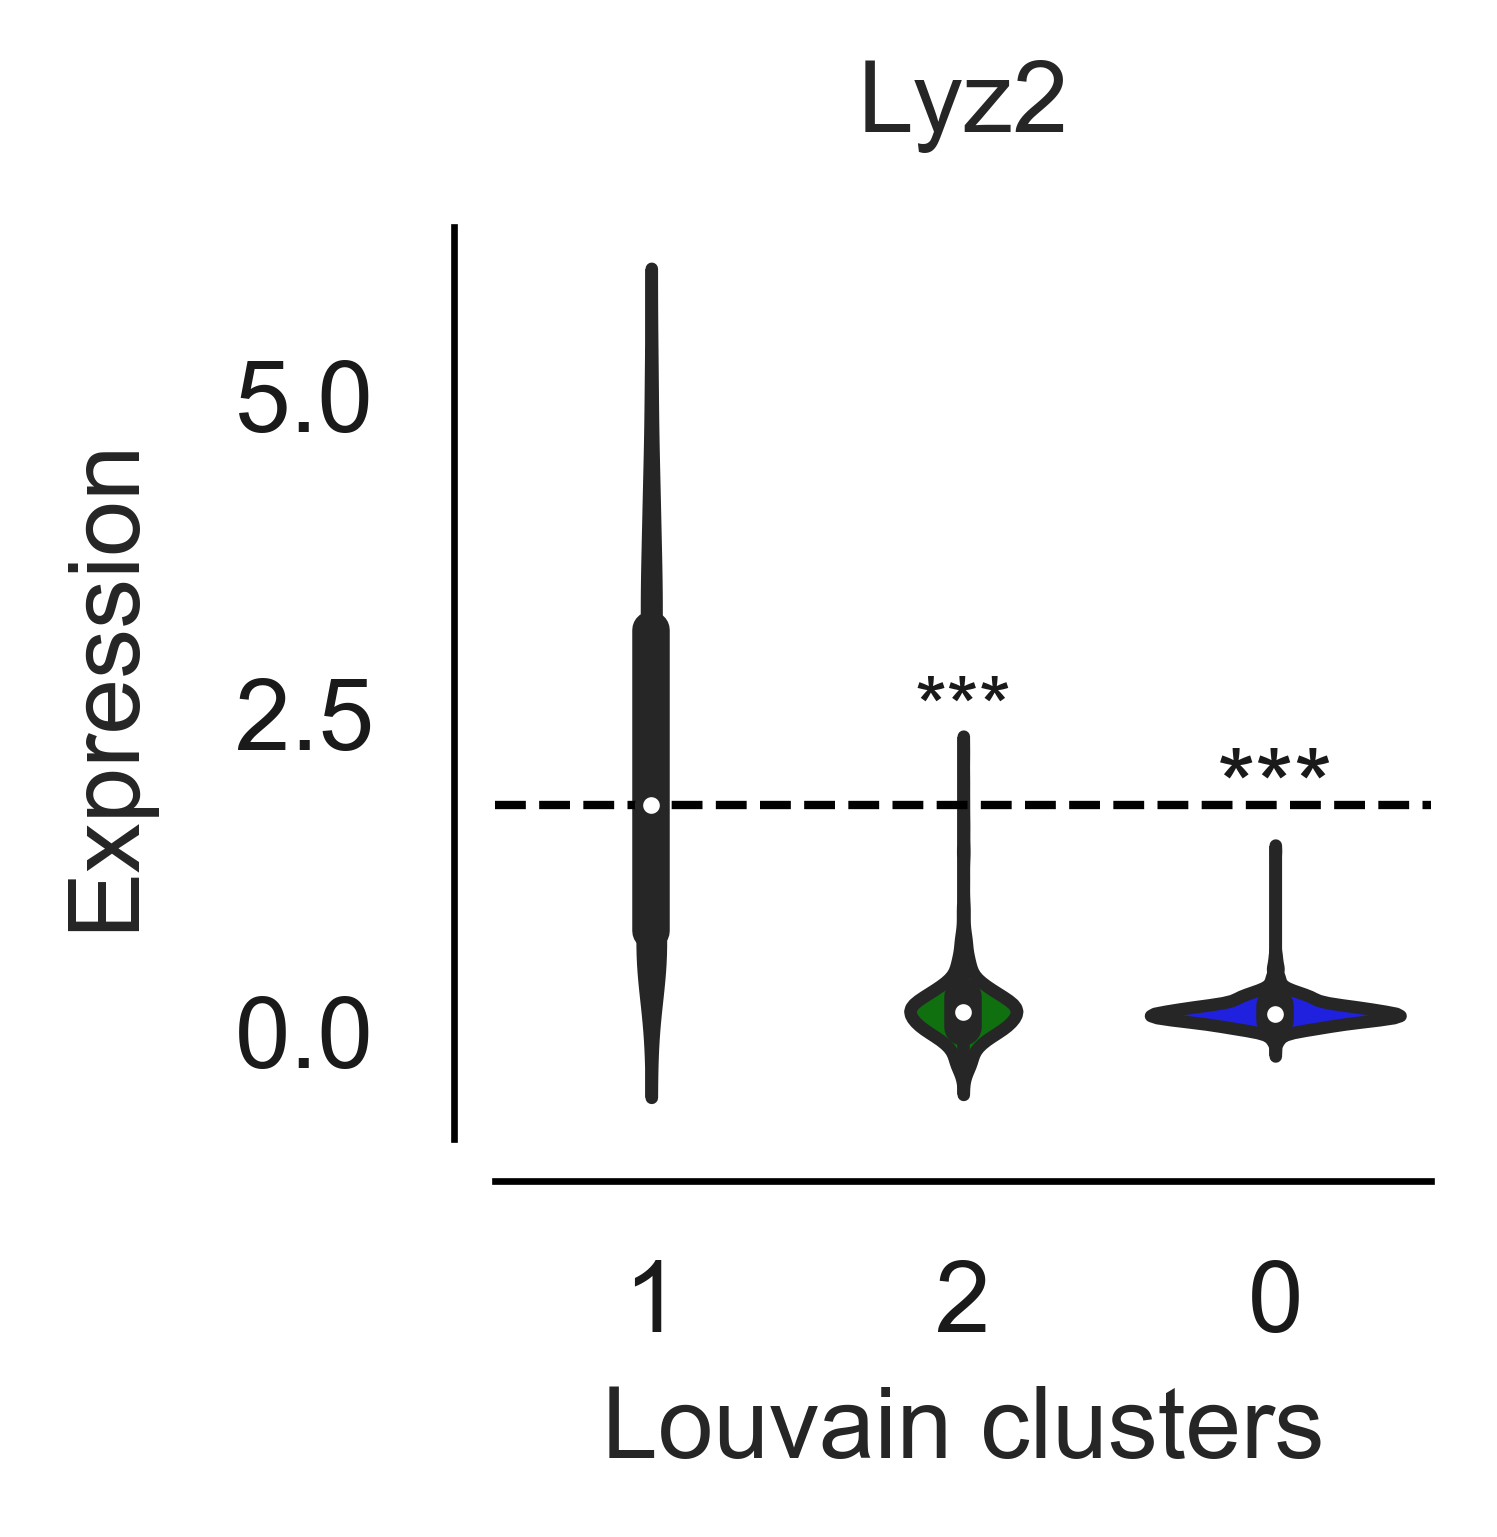

In [602]:
# Plot results

dpi=300
order=['1','2','0']

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Lyz2', x='louvain_r0.2', data=adata_subset.obs, order=order,
 palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Lyz2', fontsize=12, y=1.05)
plt.ylabel('Expression', fontsize=12, labelpad=10)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(1.777999, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Lyz2'].max() + 2.2, 2.2, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Lyz2'].max() + 1.5, 1.5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Lyz2_withstats.png', bbox_inches='tight', dpi=dpi)

### Sftpc

In [603]:
# Add gene expression to adata.obs
adata_subset.obs['Sftpc']=adata_subset[:, ['Sftpc']].to_df()

# Find medians
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Sftpc', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    1.972868
1    6.696105
2    2.365852
dtype: float32

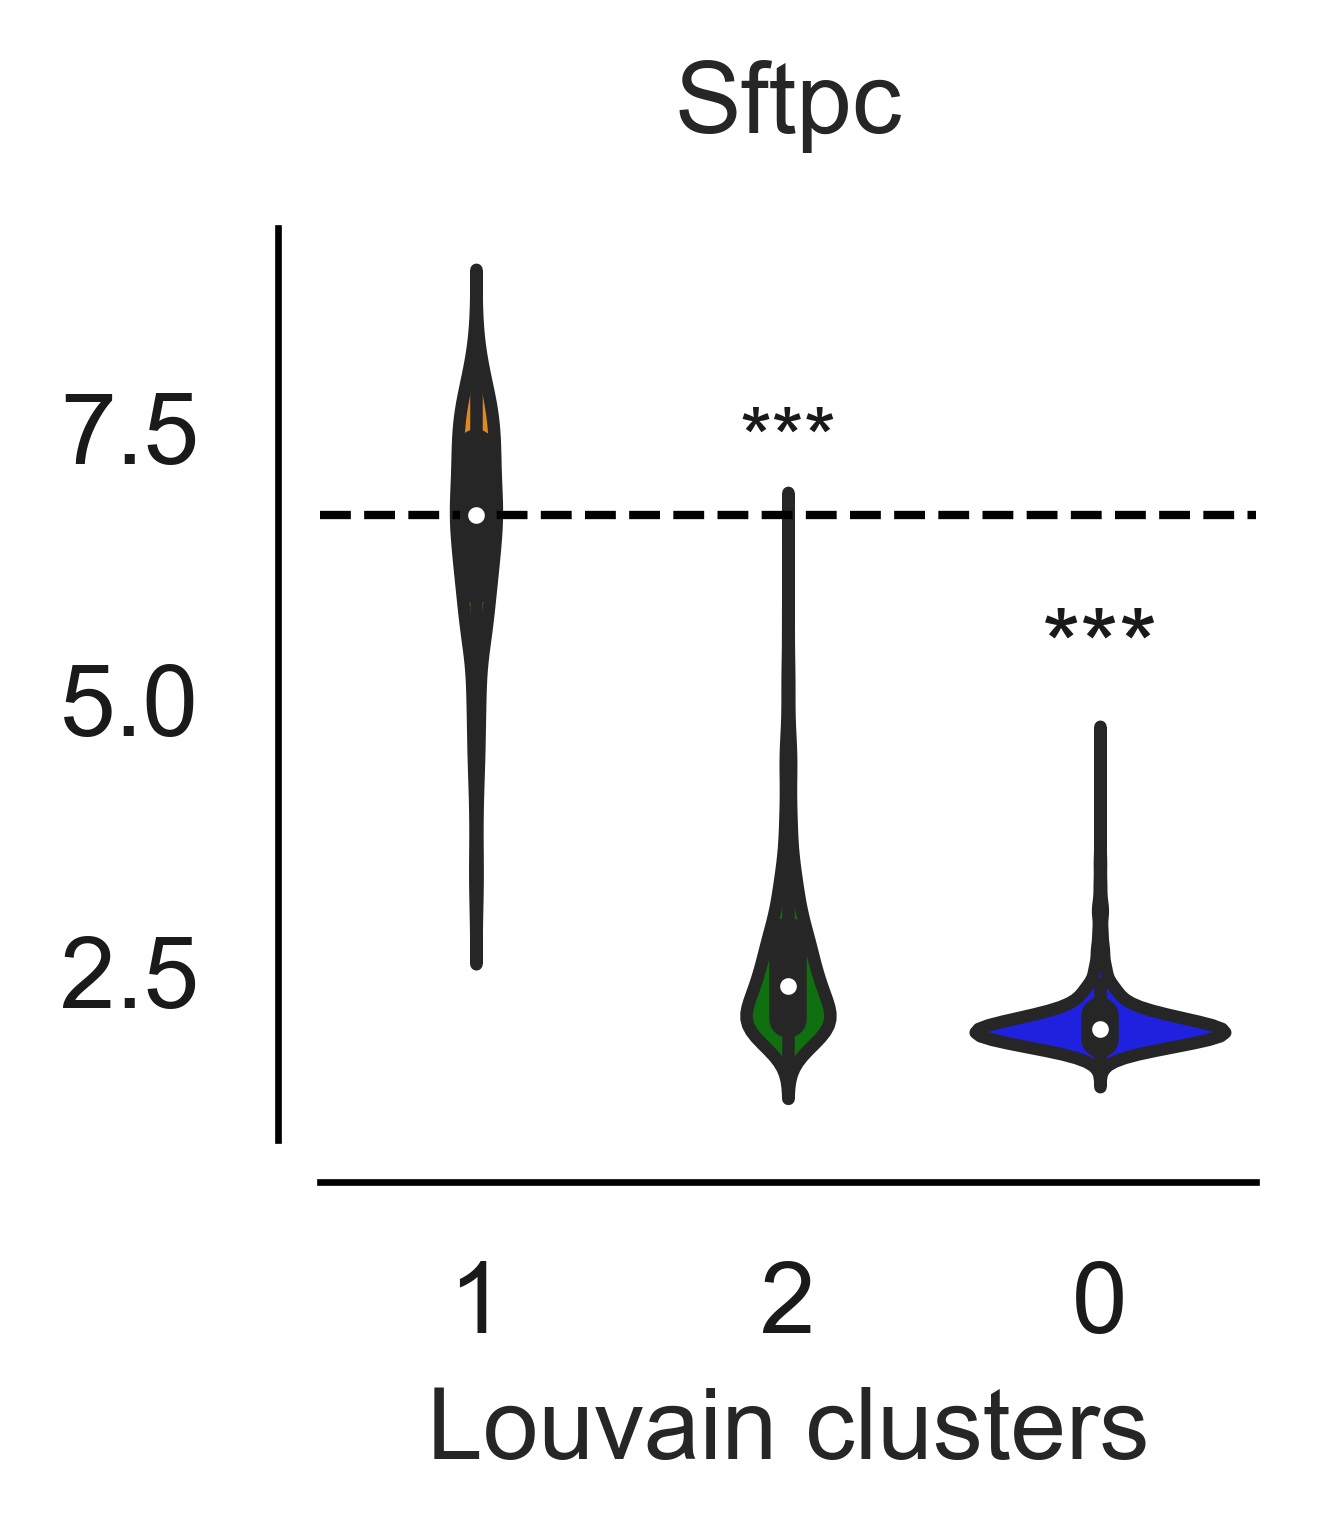

In [608]:
# Plot results

dpi=300
order=['1','2','0']

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Sftpc', x='louvain_r0.2', data=adata_subset.obs, order=order,
 palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Sftpc', fontsize=12, y=1.05)
plt.ylabel('', fontsize=12, labelpad=10)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(6.696105, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Sftpc'].max() + 7,7, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Sftpc'].max() + 5,5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Sftpc_withstats.png', bbox_inches='tight', dpi=dpi)

### Cd74

In [609]:
# Add gene expression to adata.obs
adata_subset.obs['Cd74']=adata_subset[:, ['Cd74']].to_df()

# Find medians
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Cd74', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.311065
1    3.406021
2    0.272979
dtype: float32

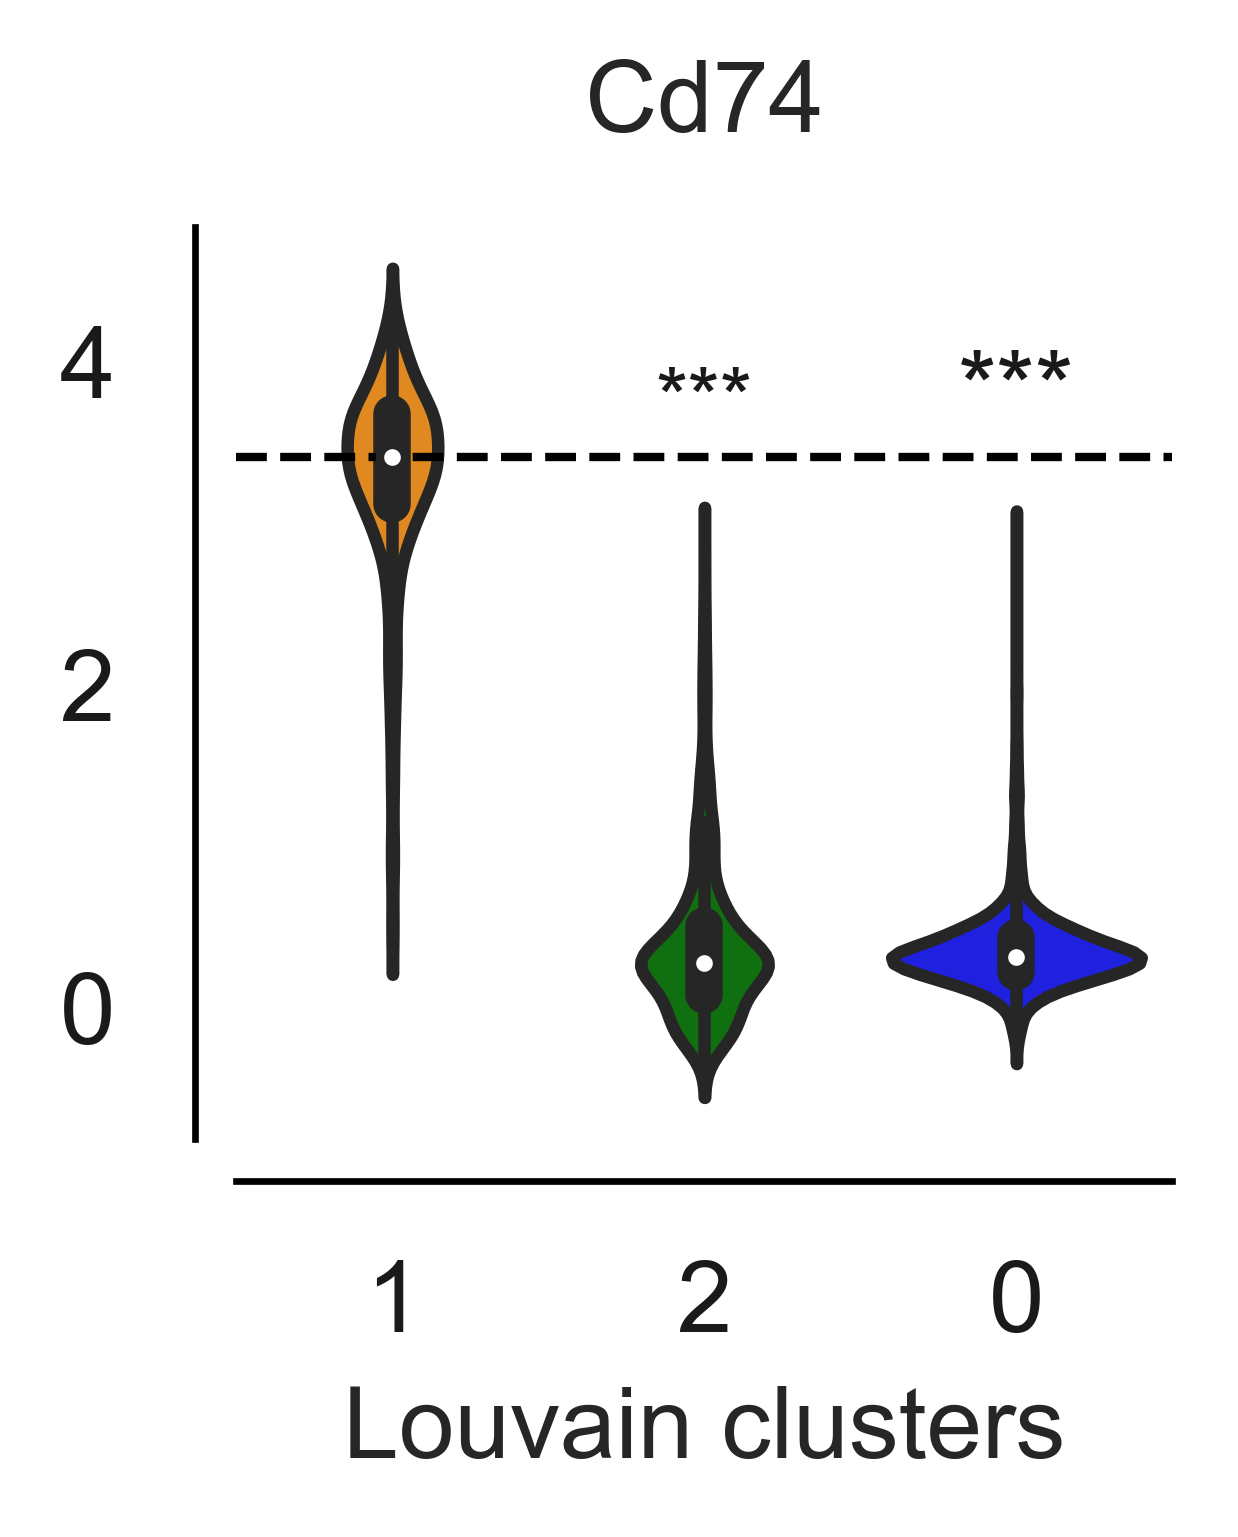

In [613]:
# Plot results

dpi=300
order=['1','2','0']

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Cd74', x='louvain_r0.2', data=adata_subset.obs, order=order,
 palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Cd74', fontsize=12, y=1.05)
plt.ylabel('', fontsize=12, labelpad=10)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(3.406021, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Cd74'].max() + 3.5,3.5, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Cd74'].max() + 3.5,3.5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Cd74_withstats.png', bbox_inches='tight', dpi=dpi)

## Nkx2-1

In [614]:
# Add gene expression to adata.obs
adata_subset.obs['Nkx2-1']=adata_subset[:, ['Nkx2-1']].to_df()

# Find medians
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Nkx2-1', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.439612
1    1.268888
2    0.762381
dtype: float32

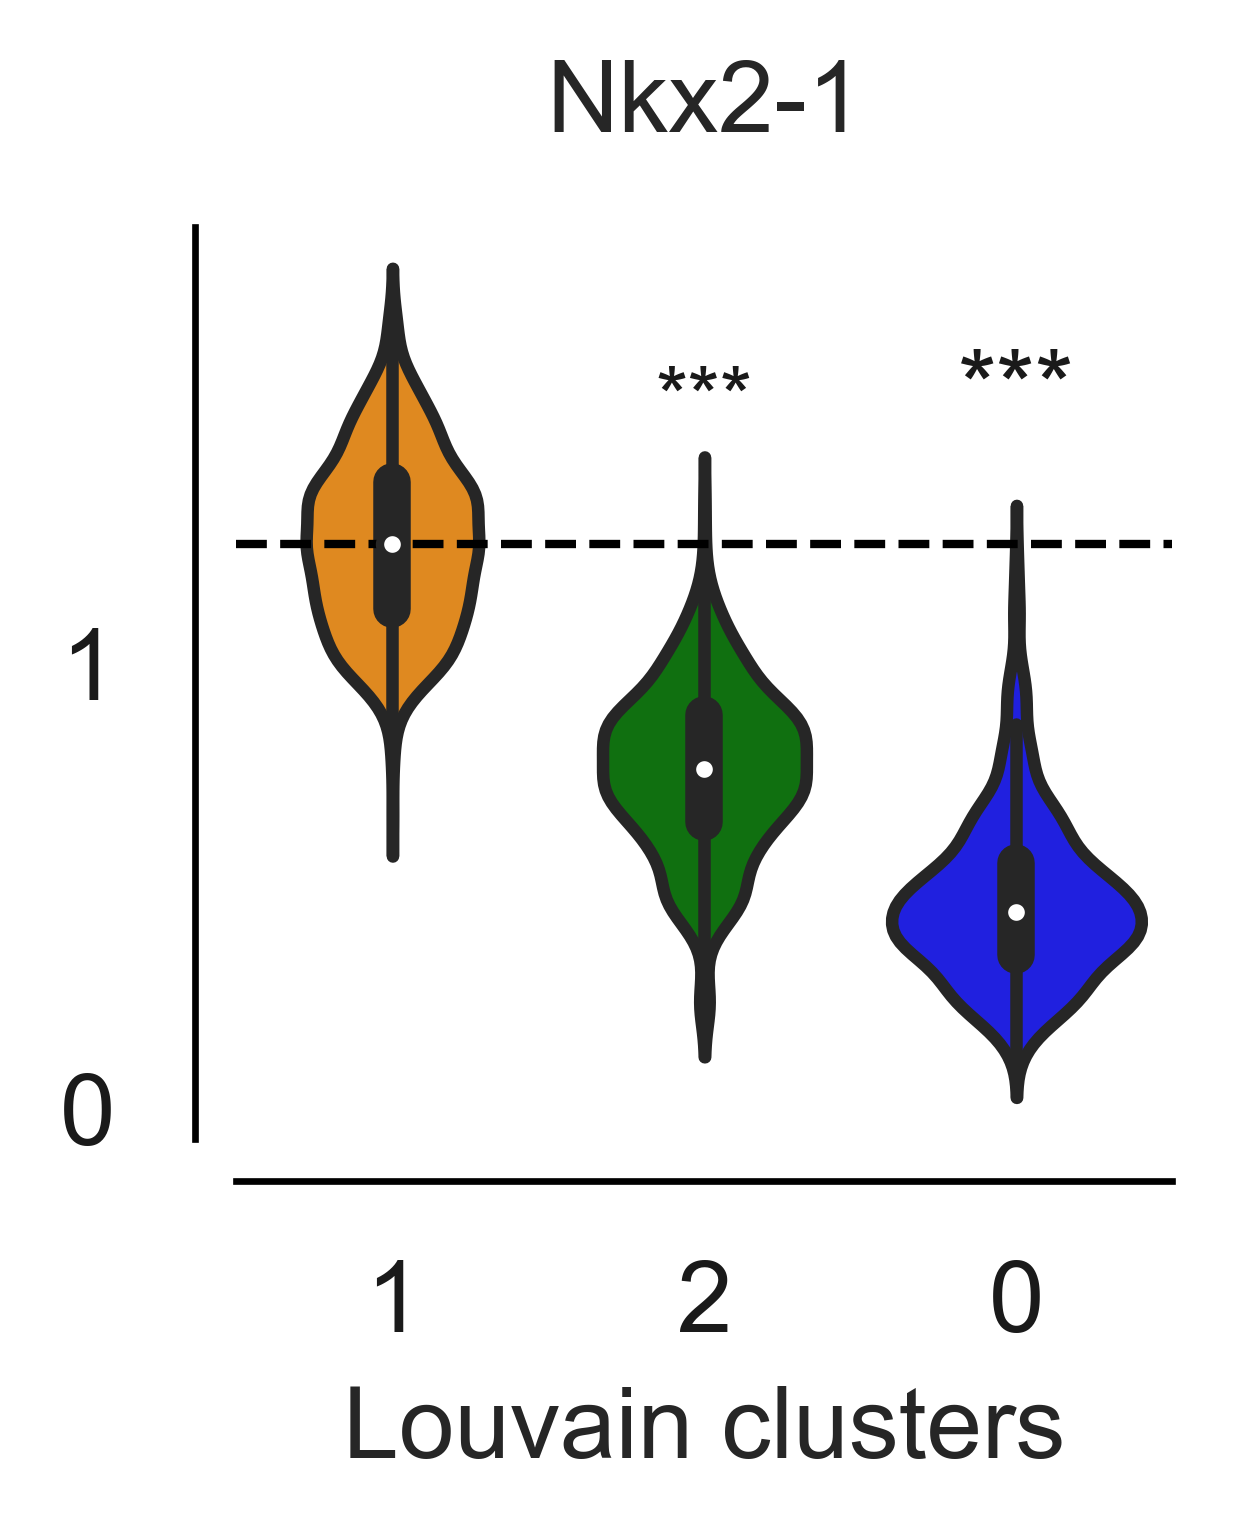

In [616]:
# Plot results

dpi=300
order=['1','2','0']

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Nkx2-1', x='louvain_r0.2', data=adata_subset.obs, order=order,
 palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Nkx2-1', fontsize=12, y=1.05)
plt.ylabel('', fontsize=12, labelpad=10)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(1.268888, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Nkx2-1'].max() + 1.5,1.5, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Nkx2-1'].max() + 1.5,1.5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Nkx2-1_withstats.png', bbox_inches='tight', dpi=dpi)

### Figure S4D

### Stacked bar plot

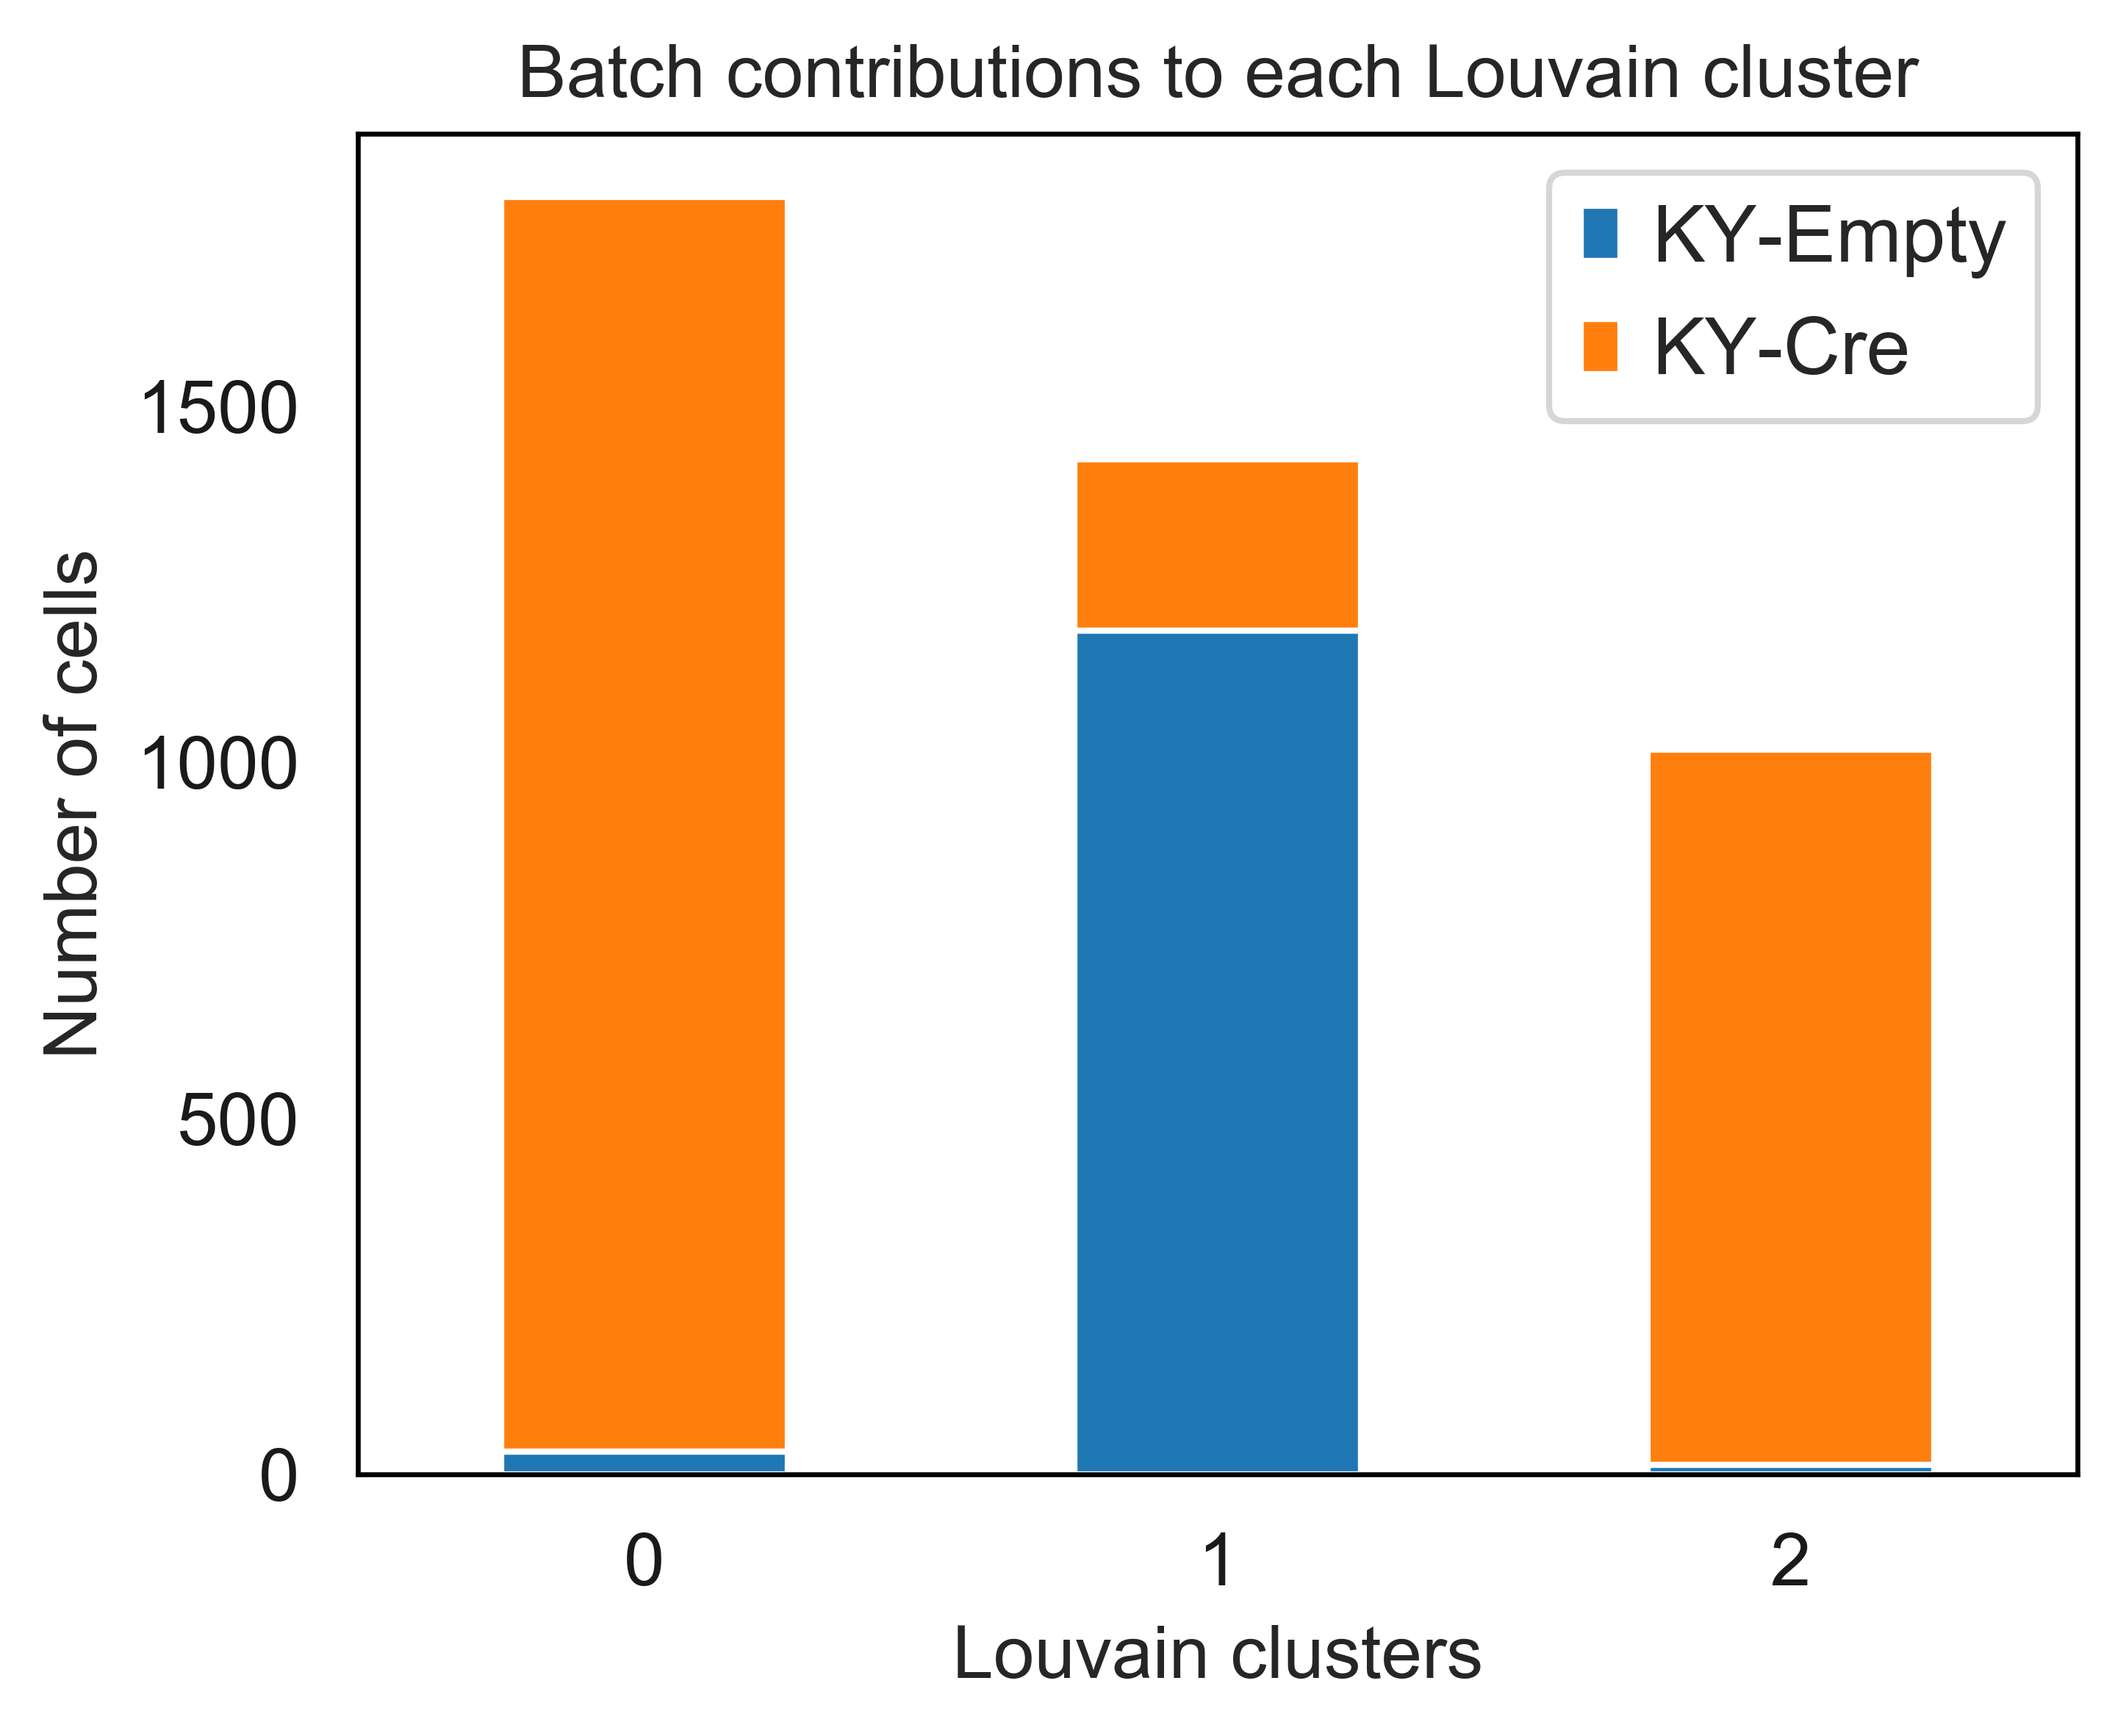

In [595]:
# Stacked bar plot

df=adata_subset.obs
df_plot = df.groupby(['batch', 'louvain_r0.2']).size().reset_index().pivot(columns='batch', index='louvain_r0.2', values=0)

rcParams['figure.figsize'] = 5,4
with axes_style({'axes.grid': False}):
 df_plot.plot(kind='bar', stacked=True)
plt.ylabel('Number of cells', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.title('Batch contributions to each Louvain cluster',fontsize=12)
plt.legend(loc='right margin')
plt.savefig('./figures/cluster_contributions.png', bbox_inches='tight')

### Differential Expression (DE) Analysis

In [276]:
# Differential expression (DE) and Enrichr analysis

# Identify DE gene using the in-built ScanPy function

# Filtered gene list for TF/TFC identification. I wanted to be stringent
sc.tl.rank_genes_groups(adata_subset, 'louvain_r0.2', method='wilcoxon', n_genes=1000, use_raw=True)

# Removed the outgroup filter, but kept the log fold change and ingroup filter
sc.tl.filter_rank_genes_groups(adata_subset, 
   min_fold_change = 1, # minimum log fold change   
   min_in_group_fraction = 0.5,  # 50% of cells in the cluster must express the gene
   max_out_group_fraction = 0.5, # No more than 50% of cells outside a cluster can express this genes
   key_added='rank_genes_groups_filtered') # filtered group key

result = adata_subset.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names

# export filtered DE results to excel 
df1=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
df1.to_excel("adata_subset_DE_top1000_filtered.xlsx", sheet_name='Top 1000 filtered')

ranking genes
    finished (0:00:06)
Filtering genes using: min_in_group_fraction: 0.5 min_fold_change: 1, max_out_group_fraction: 0.5


### Figure 4C

In [562]:
heatmap_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','mistyrose','red']) # color map

ax=sc.pl.rank_genes_groups_heatmap(adata_subset, n_genes=20,cmap=heatmap_cmap,swap_axes=True, use_raw=False, 
key='rank_genes_groups_filtered', vmin=0.2, vmax=1, show_gene_labels=True, figsize=(15,15), show=False)
plt.savefig('./figures/heatmap_top20_DE.png', bbox_inches='tight',dpi=300)

#### Transcription Factor and Co-factor identification

In [278]:
# identify all DE TF's 

# import list of mouse TFs from TFDB
# http://bioinfo.life.hust.edu.cn/AnimalTFDB/#!/species
df_tf = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='TF and TFCs Animal TFDB3', header=0) # load lists 
tf_genes = set(df_tf['Symbol'].tolist())

# Find TF/TFCs in the filtered DE genes list
diff_padj_filtered = pd.read_excel('adata_subset_DE_top1000_filtered.xlsx', header = 0) # previously generated using in built ScanPy function
names = diff_padj_filtered.columns
clust_dict = {} #key,value

for col in diff_padj_filtered.columns:
    
    # get diff gene list
    cluster_genes = diff_padj_filtered[col].tolist()

    # Create results array
    results_tfs = []

    # iterate through and pull out TF/TFCs
    
    for i in tf_genes:
     if i in cluster_genes:
      results_tfs.append(i)
    
    #store in dict (receptors,ligands,tfs)
    the_key = col
    the_value = {}
    the_value["tfs"] = results_tfs
    clust_dict[the_key] = the_value

# Create a list of identified TFs
merged_tf = []

for i in clust_dict:
    sub_dict = clust_dict[i] #access each cluster in dict
    
    # create merge
    merged_tf += sub_dict["tfs"]

### Figure S4F

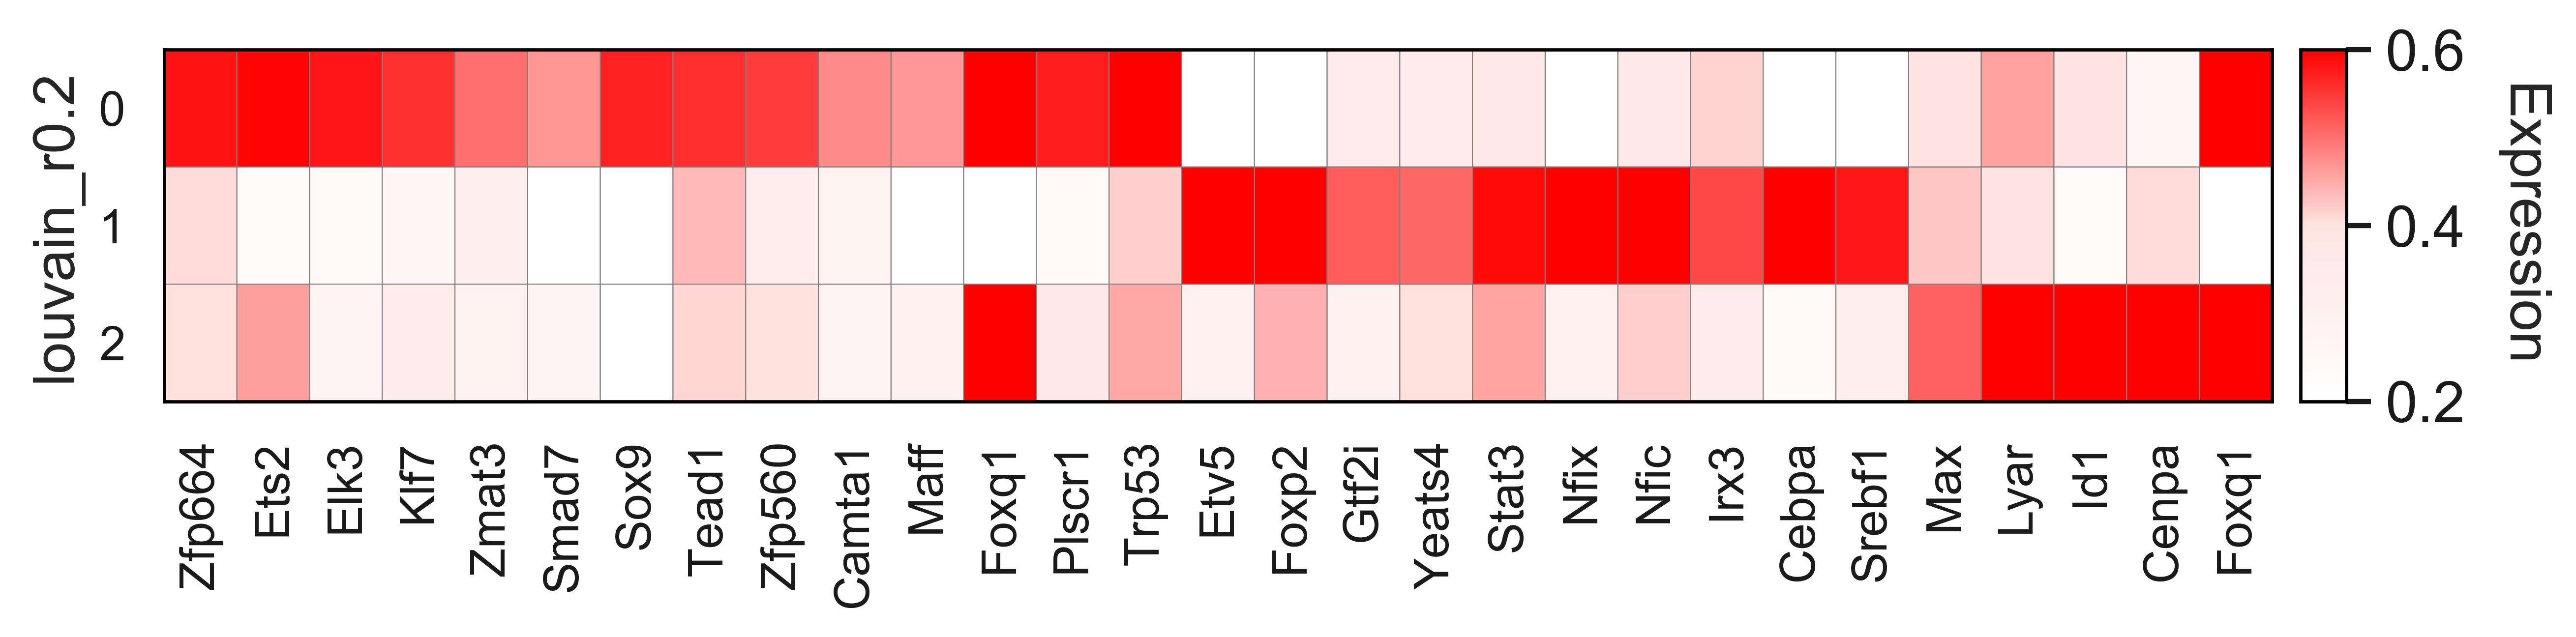

In [594]:
# Visualize data as a matrix plot

#cmap2 = 'RdYlBu_r'
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'mistyrose','red'])

sc.pl.matrixplot(adata_subset, var_names=merged_tf, cmap=cmap2, groupby='louvain_r0.2', use_raw=False, 
swap_axes=False, vmin=0.2, vmax=0.6, dendrogram=False, show=False)
plt.ylabel('Expression',fontsize=14,labelpad=20,rotation=270)
plt.savefig('./figures/matrixplot_TFs.png', bbox_inches='tight', dpi=300)

### Plot TF expression

### Figure 4D

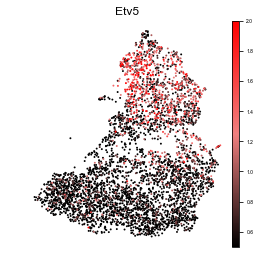

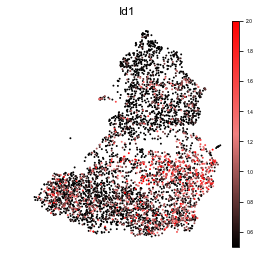

In [4]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black','lightcoral','red']) 
#cmap='plasma'
use_raw='False'
frameon=False
size=15
figsize=4,4
fontsize=12
dpi=300
tick_size=5 # https://github.com/theislab/scanpy/issues/337

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5393225/
rcParams['figure.figsize'] =  figsize
ax=sc.pl.umap(adata_subset, color=['Etv5'], color_map=cmap, frameon=frameon, vmin=0.5, vmax=2,
use_raw=use_raw, size=size, show=False)
plt.title('Etv5', fontsize=fontsize)
ax.tick_params(labelsize=tick_size)
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
plt.savefig('./figures/umap_Etv5.png', bbox_inches='tight', dpi=dpi)

rcParams['figure.figsize'] =  figsize
ax=sc.pl.umap(adata_subset, color=['Id1'], color_map=cmap, frameon=frameon, vmin=0.5, vmax=2, 
use_raw=use_raw, size=size, show=False)
plt.title('Id1', fontsize=fontsize)
ax.tick_params(labelsize=tick_size)
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
plt.savefig('./figures/umap_Id1.png', bbox_inches='tight', dpi=dpi)

### Gene Ontology (GO) Enrichment Analysis - Biological Process

In [280]:
# Unfiltered gene list for GO analysis identification. I wanted to be less stringent here
sc.tl.rank_genes_groups(adata_subset, 'louvain_r0.2', method='wilcoxon',n_genes=1000, use_raw=True)

result = adata_subset.uns['rank_genes_groups']
groups = result['names'].dtype.names

# export DE results to excel 
mouse_DE_df=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
mouse_DE_df.to_excel("adata_subset_DE_top1000_unfiltered.xlsx", sheet_name='Top 1000 unfiltered')

# Look for enriched Gene Ontology Biological Process 2018 pathways

%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
import gseapy as gp
from gseapy.plot import barplot, dotplot # only needed if you want bar and dot plots

#view available reference libraries
names = gp.get_library_name() # a list of available libraries will appear

# turn columns into lists (filtered data)
C0 = mouse_DE_df['0_n']
C1 = mouse_DE_df['1_n']
C2 = mouse_DE_df['2_n']

# drop NaN: NaNs cause enricher to break
C0=C0.dropna()
C1=C1.dropna()
C2=C2.dropna()

# GO Analysis

Cluster0_GOBio = gp.enrichr(gene_list = C0,
description='Cluster0_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster0_GOBio',
cutoff=0.05
)

Cluster1_GOBio = gp.enrichr(gene_list = C1,
description='Cluster1_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster1_GOBio',
cutoff=0.05
)

Cluster2_GOBio = gp.enrichr(gene_list = C2,
description='Cluster2_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster2_GOBio',
cutoff=0.05
)

# find unique GO terms in clusters 0, 

# filter for statistically significant terms

c0_sig = Cluster0_GOBio.res2d.loc[(Cluster0_GOBio.res2d['Adjusted P-value'] < 0.05)] 
c1_sig = Cluster1_GOBio.res2d.loc[(Cluster1_GOBio.res2d['Adjusted P-value'] < 0.05)] 
c2_sig = Cluster2_GOBio.res2d.loc[(Cluster2_GOBio.res2d['Adjusted P-value'] < 0.05)] 

c0_list = c0_sig['Term'].tolist() 
c1_list = c1_sig['Term'].tolist() 
c2_list = c2_sig['Term'].tolist() 

# look for unique and common terms in C1 and C0

c0_unique_terms = []
c1_unique_terms = []
c2_unique_terms = []
common_terms = []

for i in c0_list:
    if i not in c1_list and i not in c2_list:
        c0_unique_terms.append(i)

for i in c1_list:
    if i not in c0_list and i not in c2_list:
        c1_unique_terms.append(i)
               
for i in c2_list:
    if i not in c0_list and i not in c1_list:
        c2_unique_terms.append(i)   
        
for i in c2_list:
    if i in c0_list and i in c1_list:
        common_terms.append(i) 

ranking genes
    finished (0:00:09)


In [281]:
# Export  unique terms to excel
pd.DataFrame(c0_unique_terms).to_excel("Unique cluster 0 terms.xlsx", sheet_name='C0 unique')
pd.DataFrame(c1_unique_terms).to_excel("Unique cluster 1 terms.xlsx", sheet_name='C1 unique')
pd.DataFrame(c2_unique_terms).to_excel("Unique cluster 2 terms.xlsx", sheet_name='C2 unique')
pd.DataFrame(common_terms).to_excel("Common cluster terms.xlsx", sheet_name='common') 

### Figure S4G

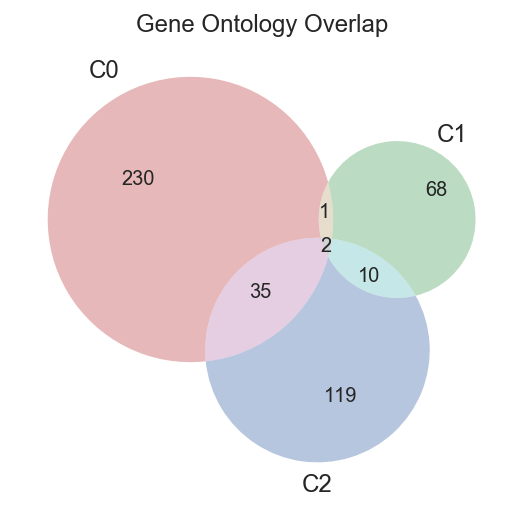

In [282]:
# plot overlap using a venn diagram and check it matches the length of the lists above

from matplotlib_venn import venn3
ax=venn3([set(c0_list), set(c1_list), set(c2_list)],set_labels = ('C0', 'C1','C2'))
plt.title('Gene Ontology Overlap', fontsize=12)
plt.savefig('./figures/venn_GO_overlap.png', bbox_inches='tight')

## Calculate signature scores

In [283]:
# Calculating z-scores for single cells

# Create an index column. Needed for single cell z-scoring

TTRUST_sox9 = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Sox9 targets TRRUST', header=0)
TTRUST_rela = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Rela targets NFKB TRRUST', header=0)
bild_kras_list = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Bild et al. 2006 (Kras genes)', header=0)
PLDB = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='AT2 marker genes (PanglaoDB)', header=0)

# sox9 list
TTRUST_activation_sox9 = TTRUST_sox9.loc[(TTRUST_sox9['Type'] == 'Activation')] # Subset genes that are activated
TTRUST_activation_sox9_list = TTRUST_activation_sox9['Target'].tolist() # Make list for visualization
TTRUST_activation_sox9_list = [x for x in TTRUST_activation_sox9_list if x in adata.var_names] # remove genes not expressed

# rela list
TTRUST_activation_rela = TTRUST_rela.loc[(TTRUST_rela['Type'] == 'Activation')] # Subset genes that are activated
TTRUST_activation_rela_list = TTRUST_activation_rela['Target'].tolist() # Make list for visualization
TTRUST_activation_rela_list = [x for x in TTRUST_activation_rela_list if x in adata.var_names] # remove genes not expressed

# kras list
bild_kras_list = bild_kras_list['GeneSymbol'].tolist() # Make list of gene names
bild_kras_list = [x.lower() for x in bild_kras_list] # lower names
bild_kras_list = [x.capitalize() for x in bild_kras_list] # capitalize names
bild_kras_list_final = [x for x in bild_kras_list if x in adata.var_names] # remove genes not in adata.var

# AT2 signature
PLDB_AT2 = PLDB.loc[(PLDB['cell type'] == 'Pulmonary alveolar type II cells') & (PLDB['species'] != 'Hs')] # Select mouse AT2 genes from database
PLDB_AT2_list = PLDB_AT2['official gene symbol'].tolist() # Make list of gene names
PLDB_AT2_list = [x.lower() for x in PLDB_AT2_list] # lower names
PLDB_AT2_list = [x.capitalize() for x in PLDB_AT2_list] # capitalize names
PLDB_AT2_list_final = [x for x in PLDB_AT2_list if x in adata.var_names] # remove genes not in adata.var

# Calculating z-scores for single cells

# create the marker dict 
marker_genes = dict()
marker_genes['Proliferation signature'] = ['Pbk','Birc5','Mki67','Ube2c','Top2a','Tk1','Aurkb','Cdkn3','Cenpf','Cdk1','Zwint']
marker_genes['Sox9_score'] = TTRUST_activation_sox9_list
marker_genes['Nfkb activation signature'] = TTRUST_activation_rela_list
marker_genes['Kras activation signature'] = bild_kras_list_final
marker_genes['AT2 signature'] = PLDB_AT2_list_final

# Calculate score
def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
        
    
    # I created a column based on index. This allows z-score calculation on single cells rather than clusters
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True) # try changing this to anndata_raw as a separate function

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

   # Return the median of all the variances over the clusters
    #marker_matches = ([np.median(variances), marker_res_df])
    
   # return marker_matches

# Calculate the z-score
df = evaluate_partition(adata_subset, marker_genes, gene_symbol_key=None, partition_key = 'index1')

# Transpose the dataframe
df_transposed = df.transpose()

# save signatures
adata_subset.obs['Proliferation signature'] = df_transposed['Proliferation signature']
adata_subset.obs['Sox9_score'] = df_transposed['Sox9_score']
adata_subset.obs['Nfkb activation signature'] = df_transposed['Nfkb activation signature']
adata_subset.obs['Kras activation signature'] = df_transposed['Kras activation signature']
adata_subset.obs['AT2 signature'] = df_transposed['AT2 signature']

## Visualize the scores

### Sox9 signature

### Figure 5B

In [292]:
adata_subset.obs['Sox9']=adata_subset[:, ['Sox9']].to_df() 
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Sox9_score', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.178472
1   -0.194389
2   -0.192999
dtype: float64

In [336]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]


# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat1['Sox9_score'], cat2['Sox9_score']) # not significant
mannwhitneyu(cat1['Sox9_score'], cat0['Sox9_score']) # significant

# figure out a more automated way of doing this!

MannwhitneyuResult(statistic=796240.0, pvalue=8.940037120179113e-76)

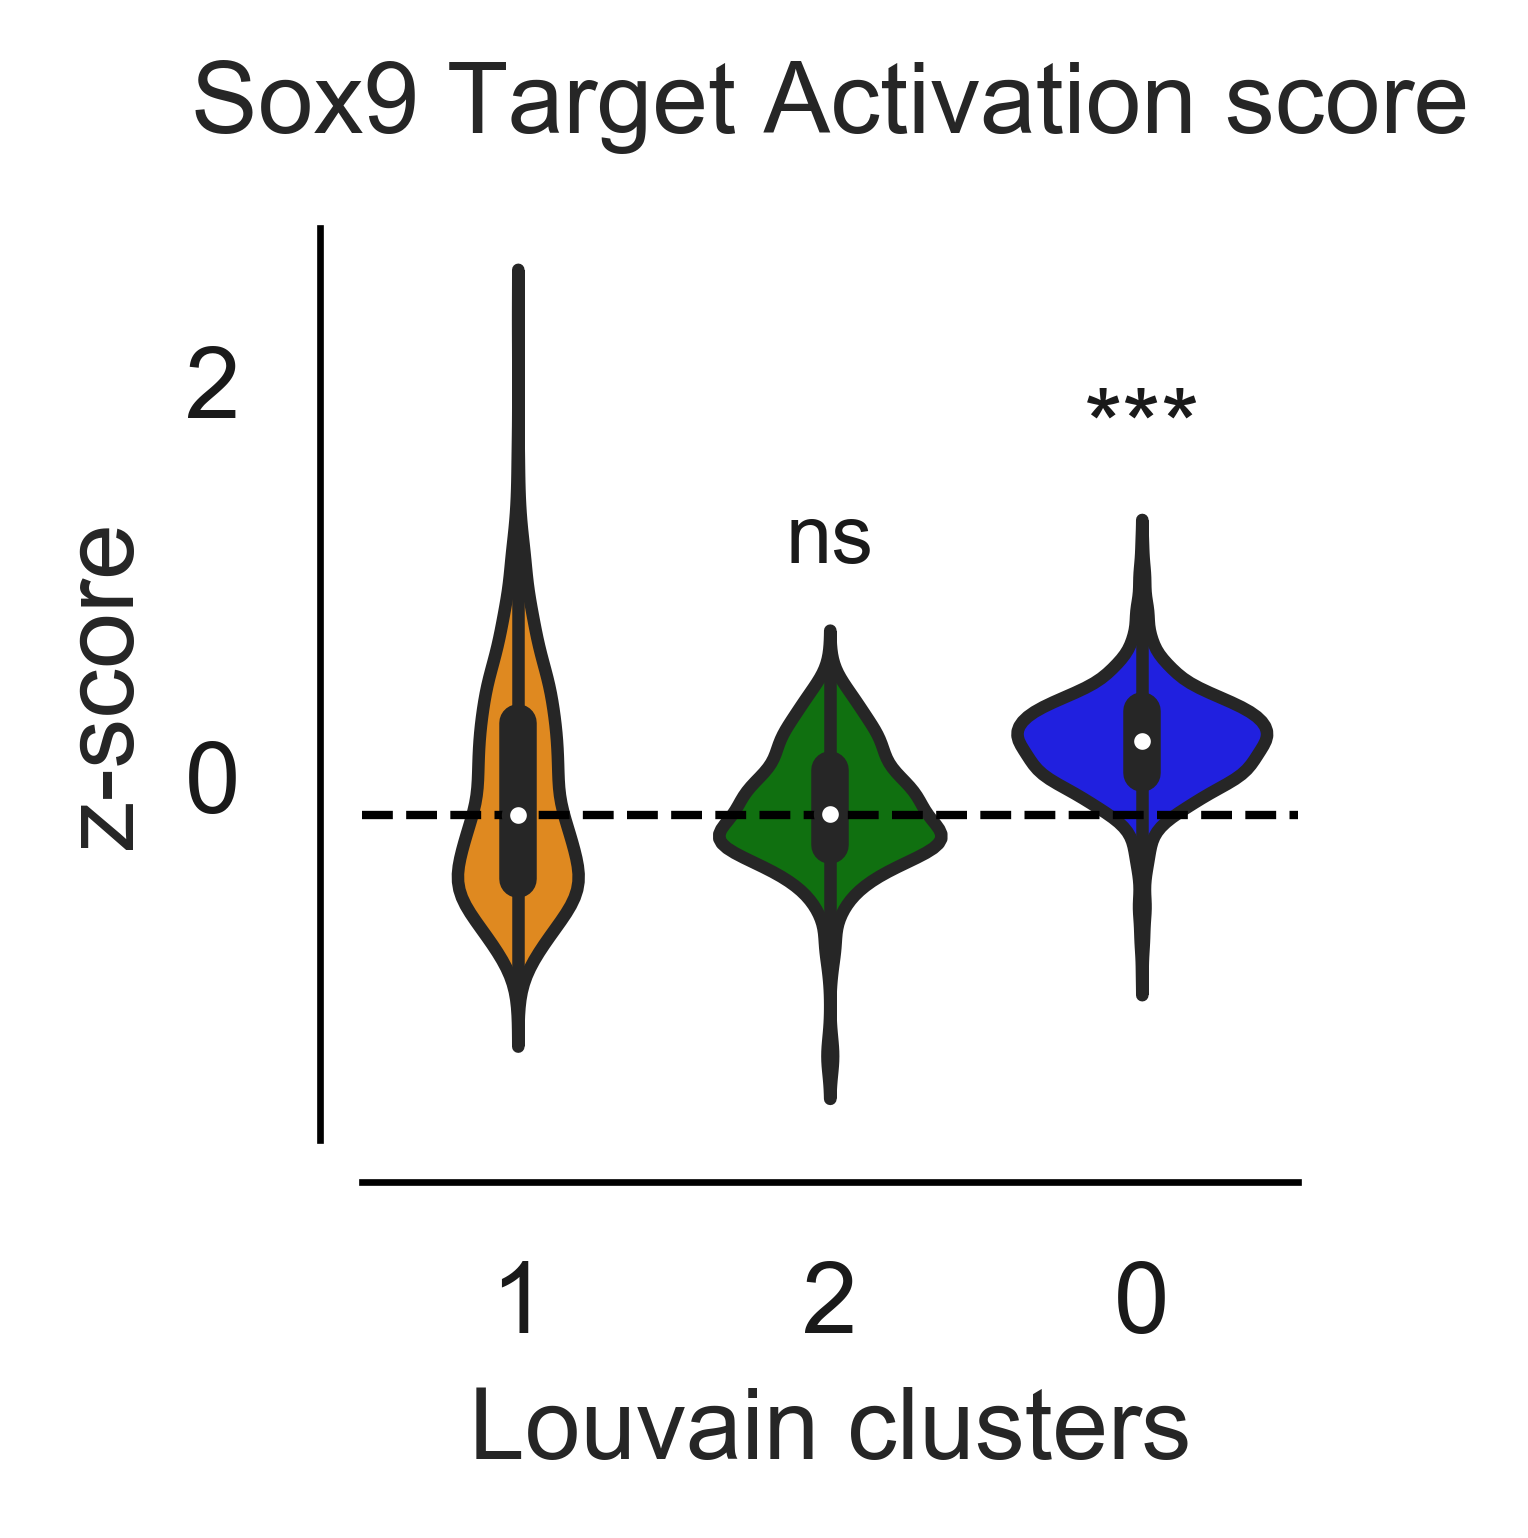

In [550]:
# Plot results

dpi=300
order=['1','2','0']

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Sox9_score', x='louvain_r0.2', data=adata_subset.obs, order=order,
                   palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Sox9 Target Activation score', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(-0.194389, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Sox9_score'].max() + 1, 1, 'k'
plt.text(x1, h, "ns", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Sox9_score'].max() + 1.5, 1.5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/sox9_score_withstats.png', bbox_inches='tight', dpi=dpi)

## Sox9

### Figure 5A

In [531]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Sox9', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.552444
1    0.066402
2    0.159835
dtype: float32

In [537]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]


# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat1['Sox9'], cat2['Sox9']) # significant
mannwhitneyu(cat1['Sox9'], cat0['Sox9']) # significant

# figure out a more automated way of doing this!

MannwhitneyuResult(statistic=284872.0, pvalue=7.434361733541274e-145)

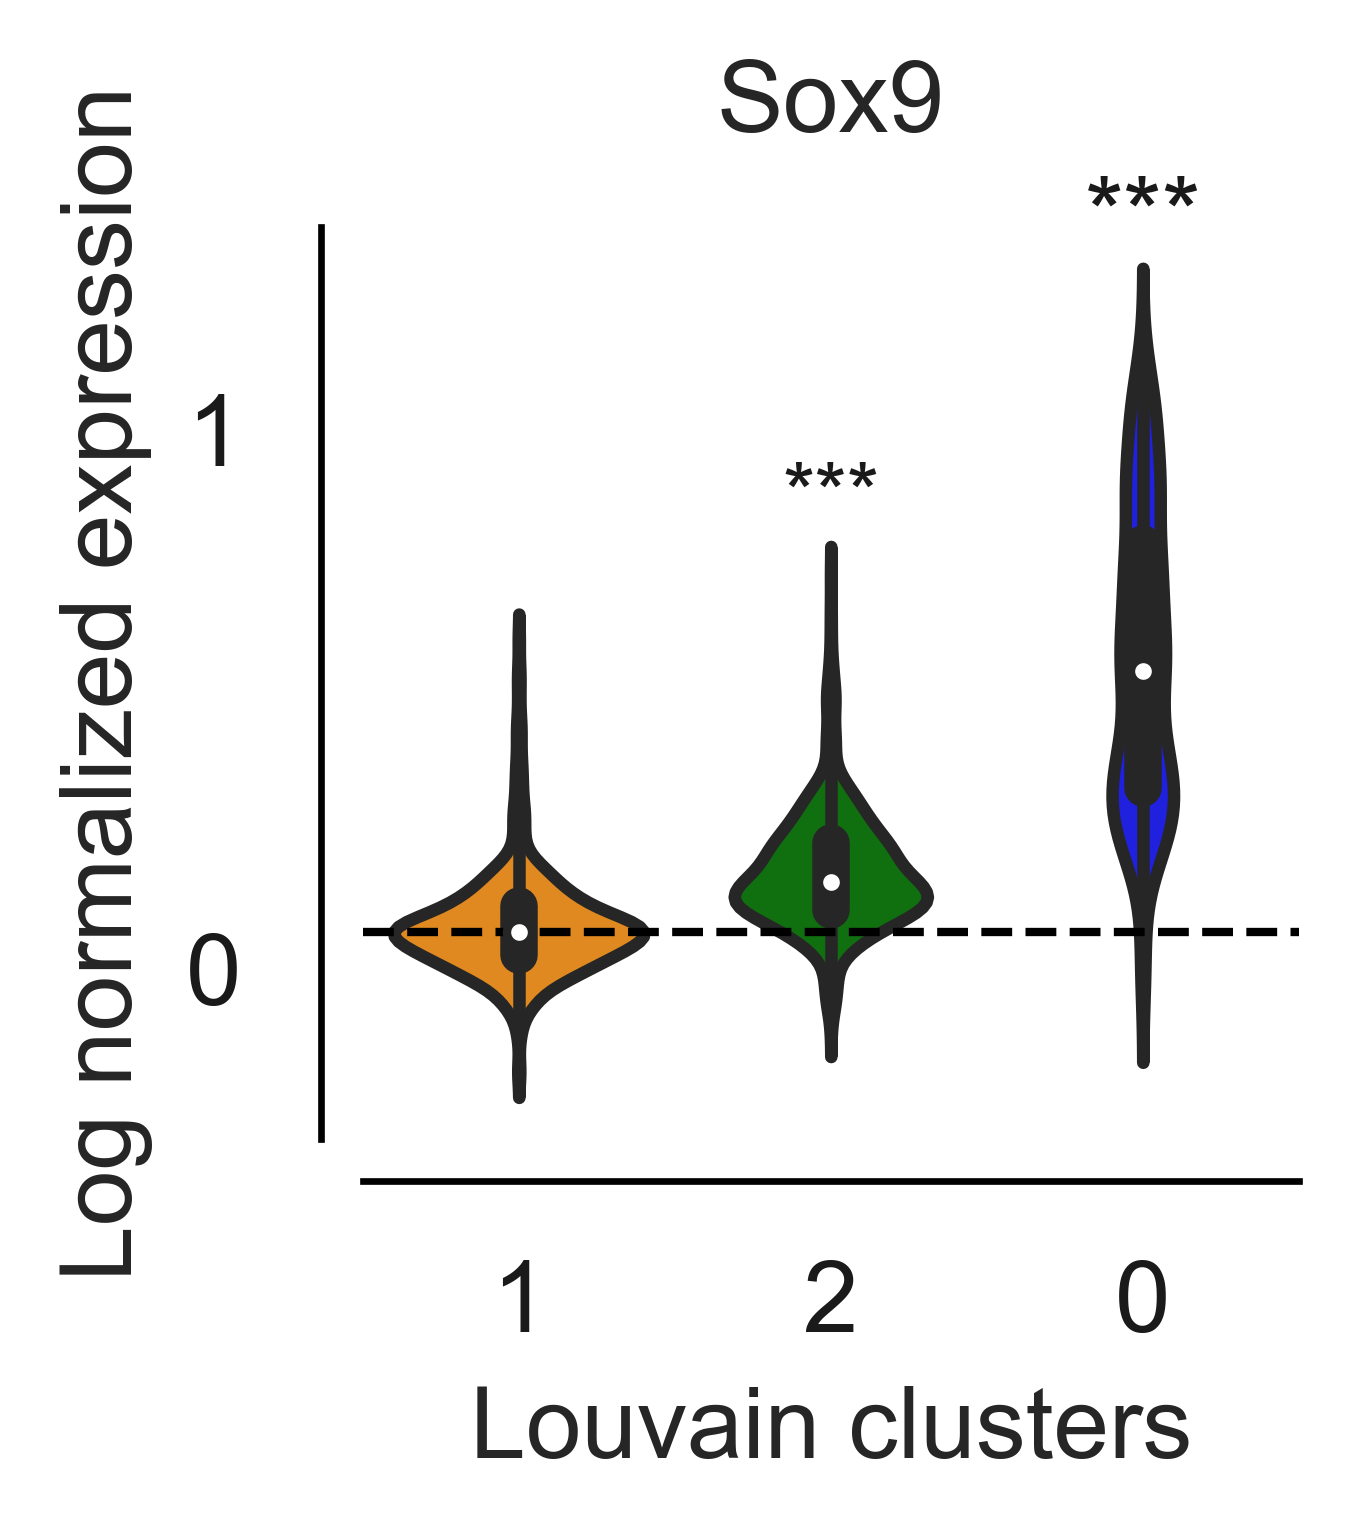

In [547]:
# Plot results
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=300
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Sox9', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'],
                   palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Sox9', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.066402, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Sox9'].max() + 0.8, 0.8, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Sox9'].max() + 1.3, 1.3, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Sox9_withstats.png', bbox_inches='tight')

##  Hmga2

### Figure 5C

In [543]:
adata_subset.obs['Hmga2']=adata_subset[:, ['Hmga2']].to_df()
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Hmga2', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.448435
1    0.000864
2    0.154369
dtype: float32

In [545]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]


# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat1['Hmga2'], cat2['Hmga2']) # significant
mannwhitneyu(cat1['Hmga2'], cat0['Hmga2']) # significant

# figure out a more automated way of doing this!

MannwhitneyuResult(statistic=35548.0, pvalue=0.0)

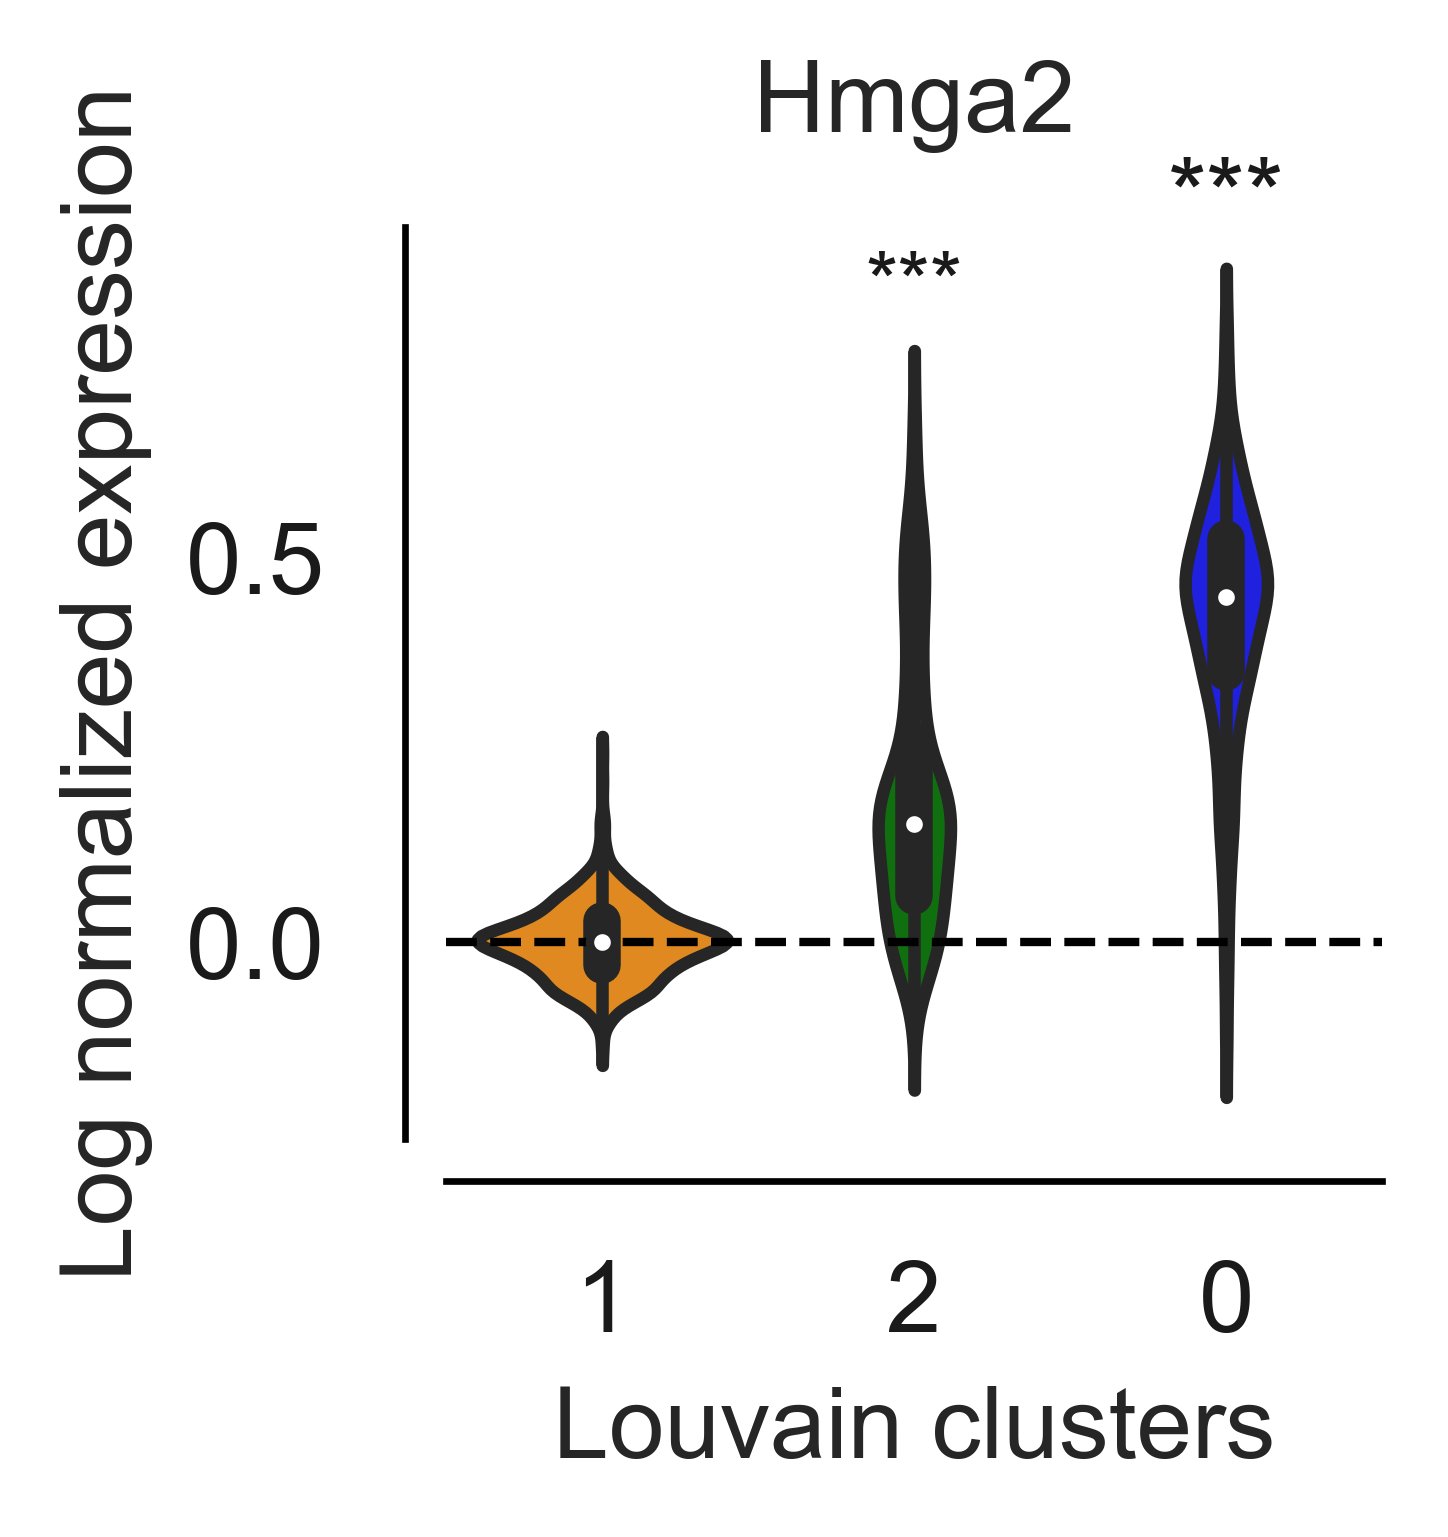

In [549]:
# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Hmga2', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'],
    palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Hmga2', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.000864, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Hmga2'].max() + 0.8, 0.8, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Sox9'].max() + 0.9, 0.9, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Hmga2_withstats.png', bbox_inches='tight', dpi=300)

## Ly6a

### Figure 5D

In [551]:
adata_subset.obs['Ly6a']=adata_subset[:, ['Ly6a']].to_df()
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Ly6a', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    2.699185
1    0.211883
2    2.642920
dtype: float32

In [ ]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat1['Ly6a'], cat2['Ly6a']) # significant
mannwhitneyu(cat1['Ly6a'], cat0['Ly6a']) # significant

# figure out a more automated way of doing this!

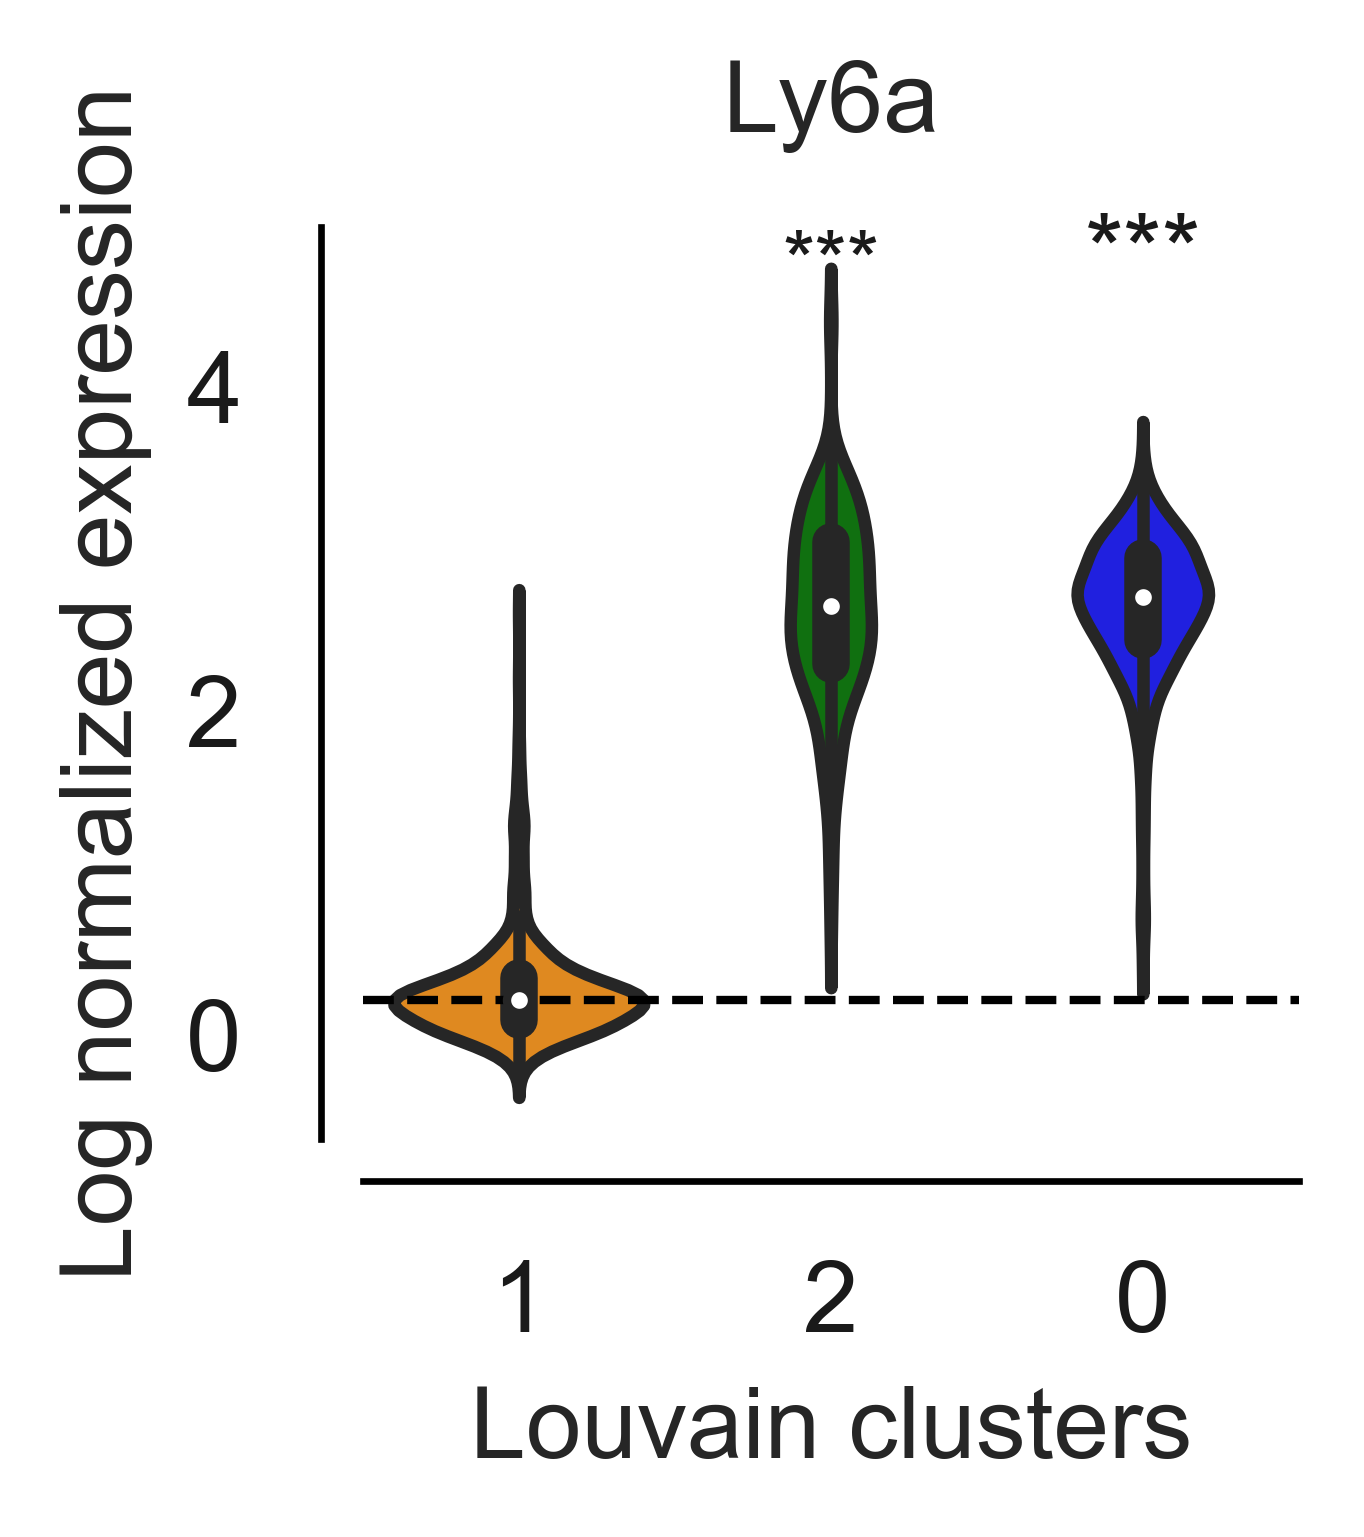

In [555]:
# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Ly6a', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'],
    palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Ly6a', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.211883, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Ly6a'].max() + 4.5, 4.5, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Sox9'].max() + 4.5, 4.5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Ly6a_withstats.png', bbox_inches='tight', dpi=300)

### Figure 4F

### Proliferation signature

In [345]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Proliferation signature', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0   -0.463778
1   -0.437780
2    0.397201
dtype: float64

In [351]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]


# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
#mannwhitneyu(cat1['Proliferation signature'], cat2['Proliferation signature']) # significant
mannwhitneyu(cat1['Proliferation signature'], cat0['Proliferation signature']) # significant

# figure out a more automated way of doing this!

MannwhitneyuResult(statistic=1211727.0, pvalue=0.005988712235375603)

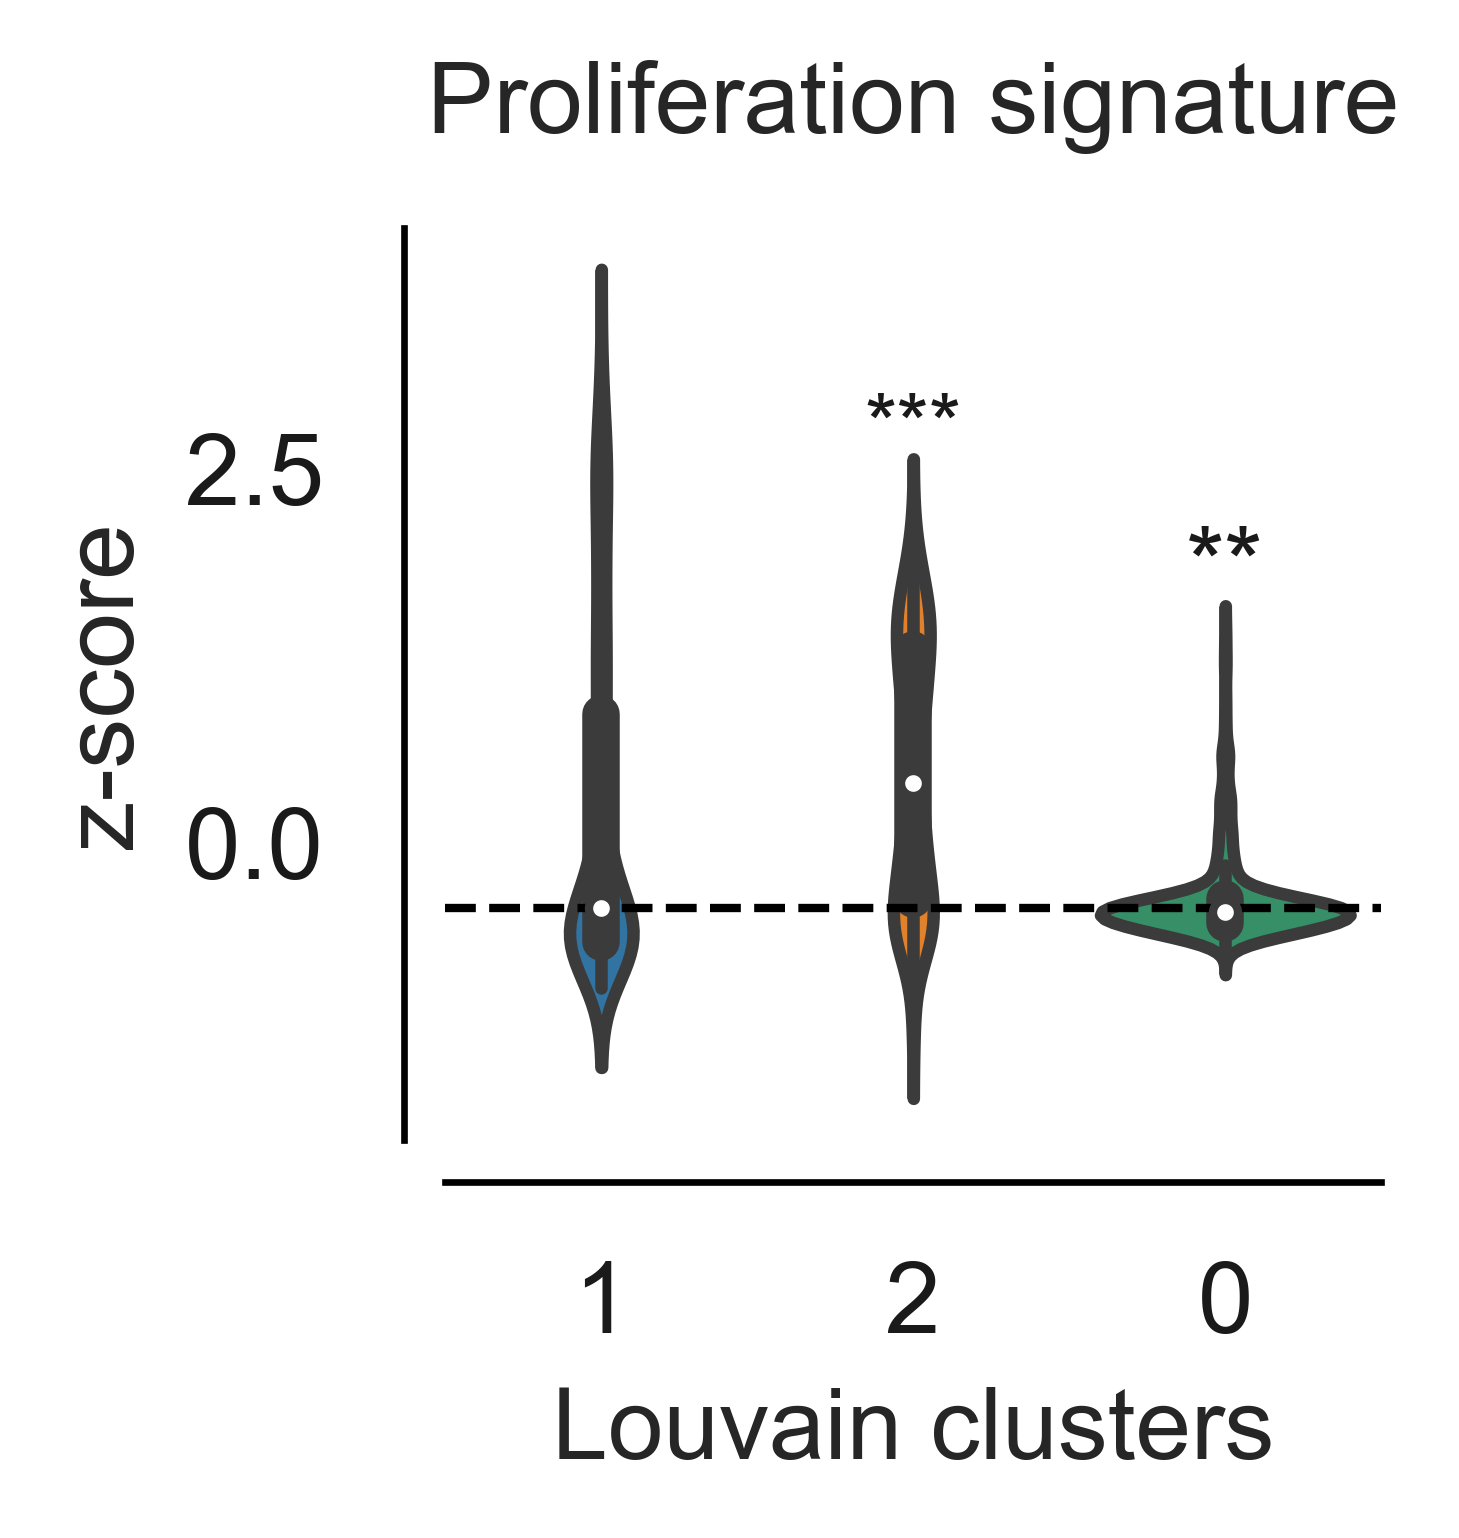

In [575]:
# Plot results
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=300
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Proliferation signature', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'])
despine(right=True, offset=5)
plt.title('Proliferation signature', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(-0.437780, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Proliferation signature'].max() + 2.5, 2.5, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Proliferation signature'].max() + 1.5, 1.5, 'k'
plt.text(x2, h, "**", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Proliferation signature_withstats.png', bbox_inches='tight')

## Nfkb signature

In [568]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Nfkb activation signature', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.127785
1   -0.200116
2   -0.273622
dtype: float64

In [571]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]


# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat1['Nfkb activation signature'], cat2['Nfkb activation signature']) # significant
mannwhitneyu(cat1['Nfkb activation signature'], cat0['Nfkb activation signature']) # significant

# figure out a more automated way of doing this!

MannwhitneyuResult(statistic=609024.0, pvalue=8.52057715192317e-12)

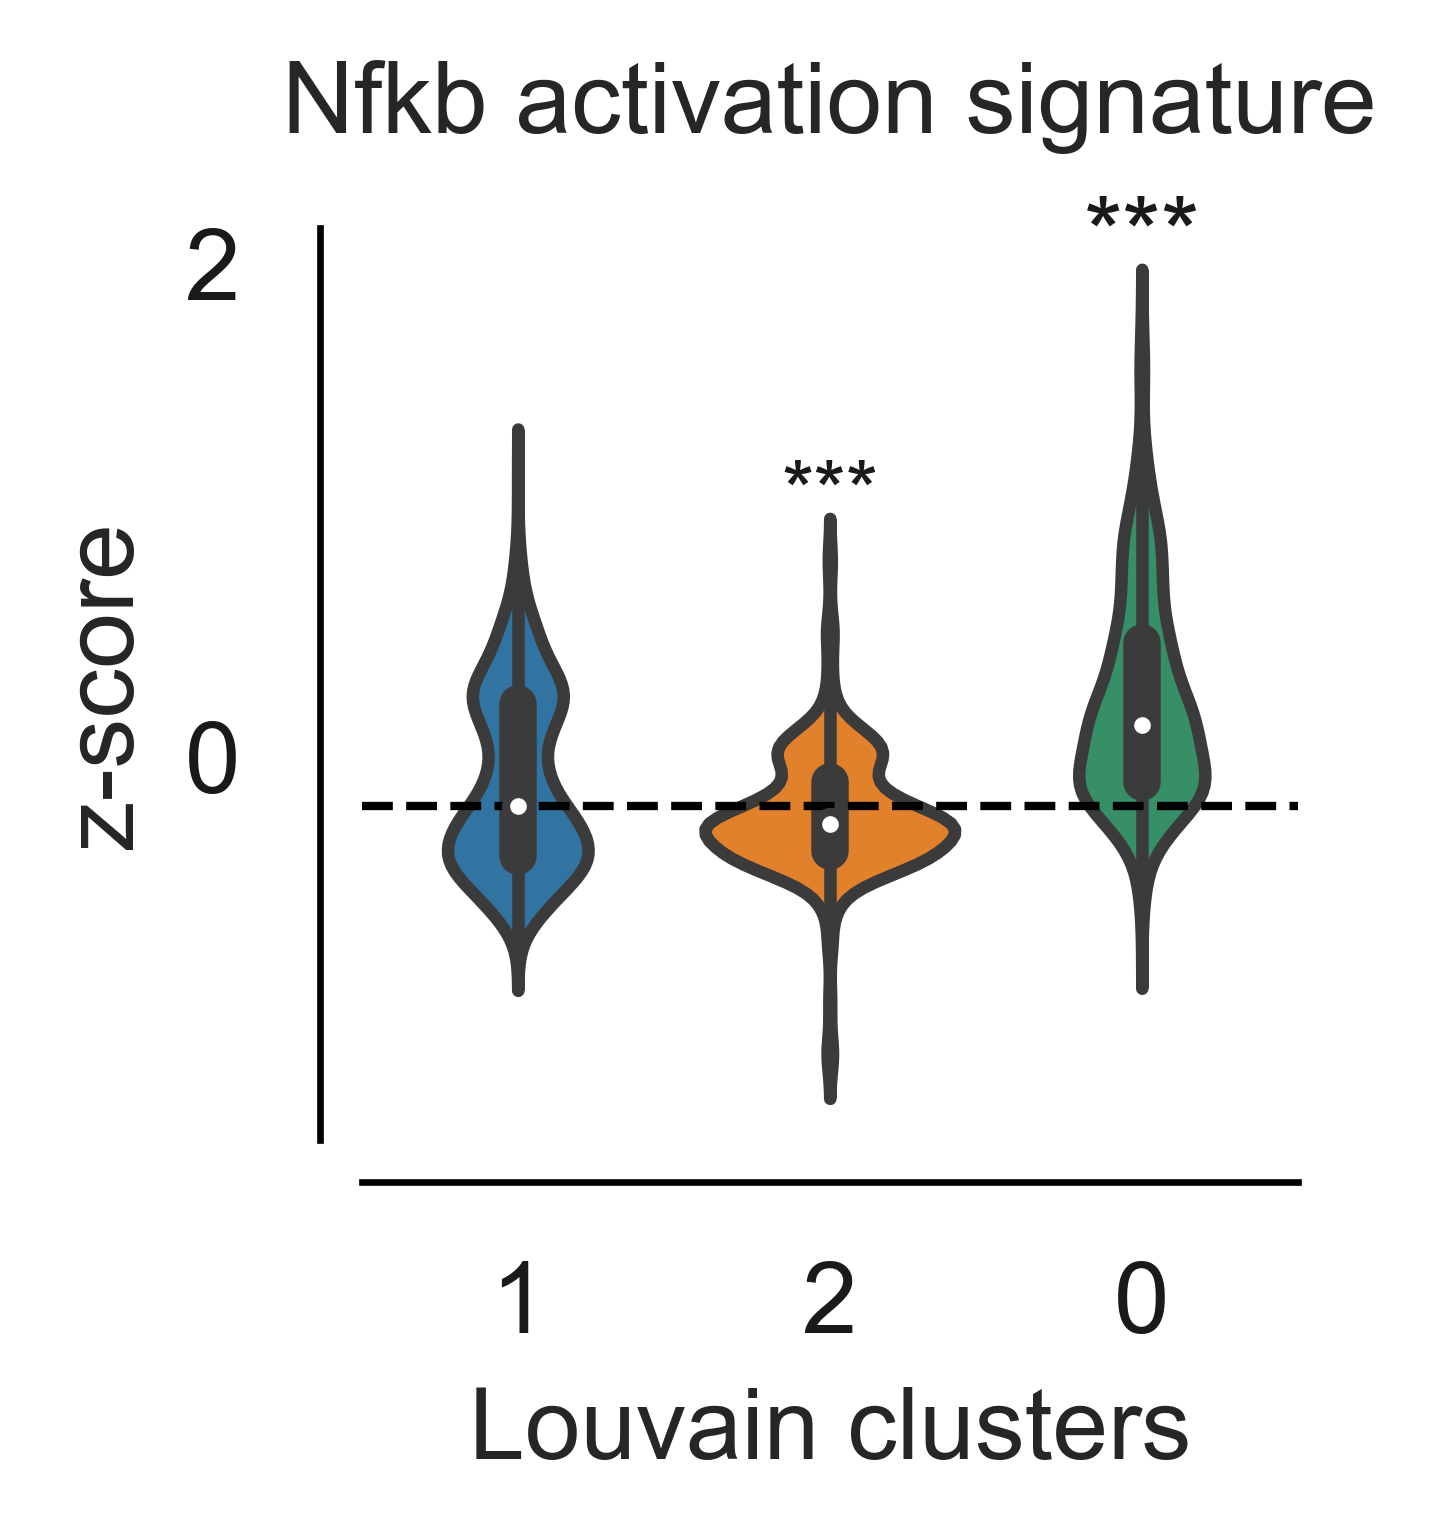

In [574]:
# Plot results
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=300
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Nfkb activation signature', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'])
despine(right=True, offset=5)
plt.title('Nfkb activation signature', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(-0.200116, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Nfkb activation signature'].max() + 0.9, 0.9, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Nfkb activation signature'].max() + 1.9, 1.9, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Nfkb signature_withstats.png', bbox_inches='tight')

## Kras signature

In [577]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Kras activation signature', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.104554
1   -0.208625
2   -0.015615
dtype: float64

In [579]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]


# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat1['Kras activation signature'], cat2['Kras activation signature']) # significant
mannwhitneyu(cat1['Kras activation signature'], cat0['Kras activation signature']) # significant

# figure out a more automated way of doing this!

MannwhitneyuResult(statistic=405507.0, pvalue=2.42953184179876e-77)

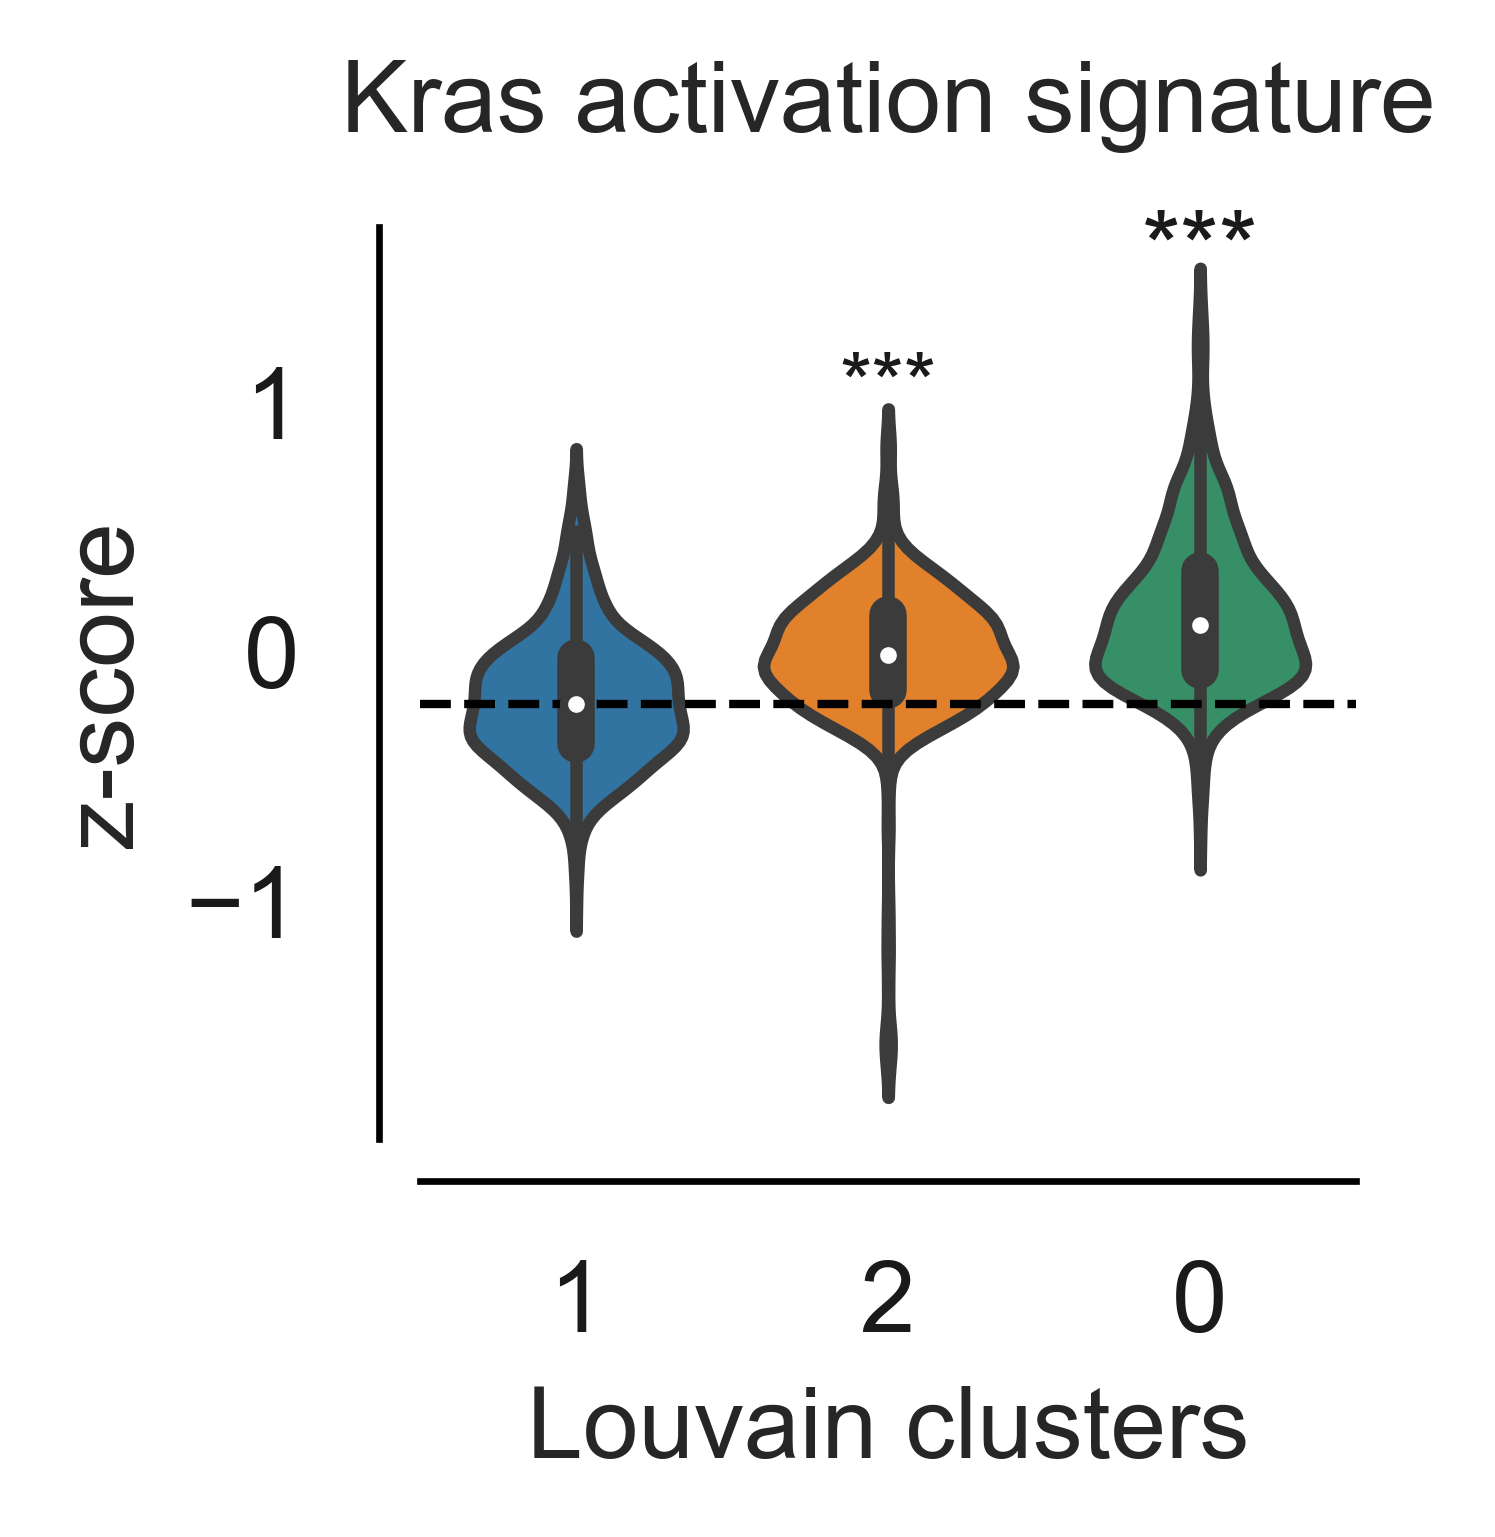

In [583]:
# Plot results
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=300
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Kras activation signature', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'])
despine(right=True, offset=5)
plt.title('Kras activation signature', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(-0.208625, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Kras activation signature'].max() + 0.9, 0.9, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Kras activation signature'].max() + 1.4, 1.4, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Kras signature_withstats.png', bbox_inches='tight')

### AT2 signature

### Figure S4H

In [357]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='AT2 signature', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0   -0.516608
1    0.818585
2   -0.302857
dtype: float64

In [359]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]


# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat1['AT2 signature'], cat2['AT2 signature']) # significant
mannwhitneyu(cat1['AT2 signature'], cat0['AT2 signature']) # significant

# figure out a more automated way of doing this!

MannwhitneyuResult(statistic=802.0, pvalue=0.0)

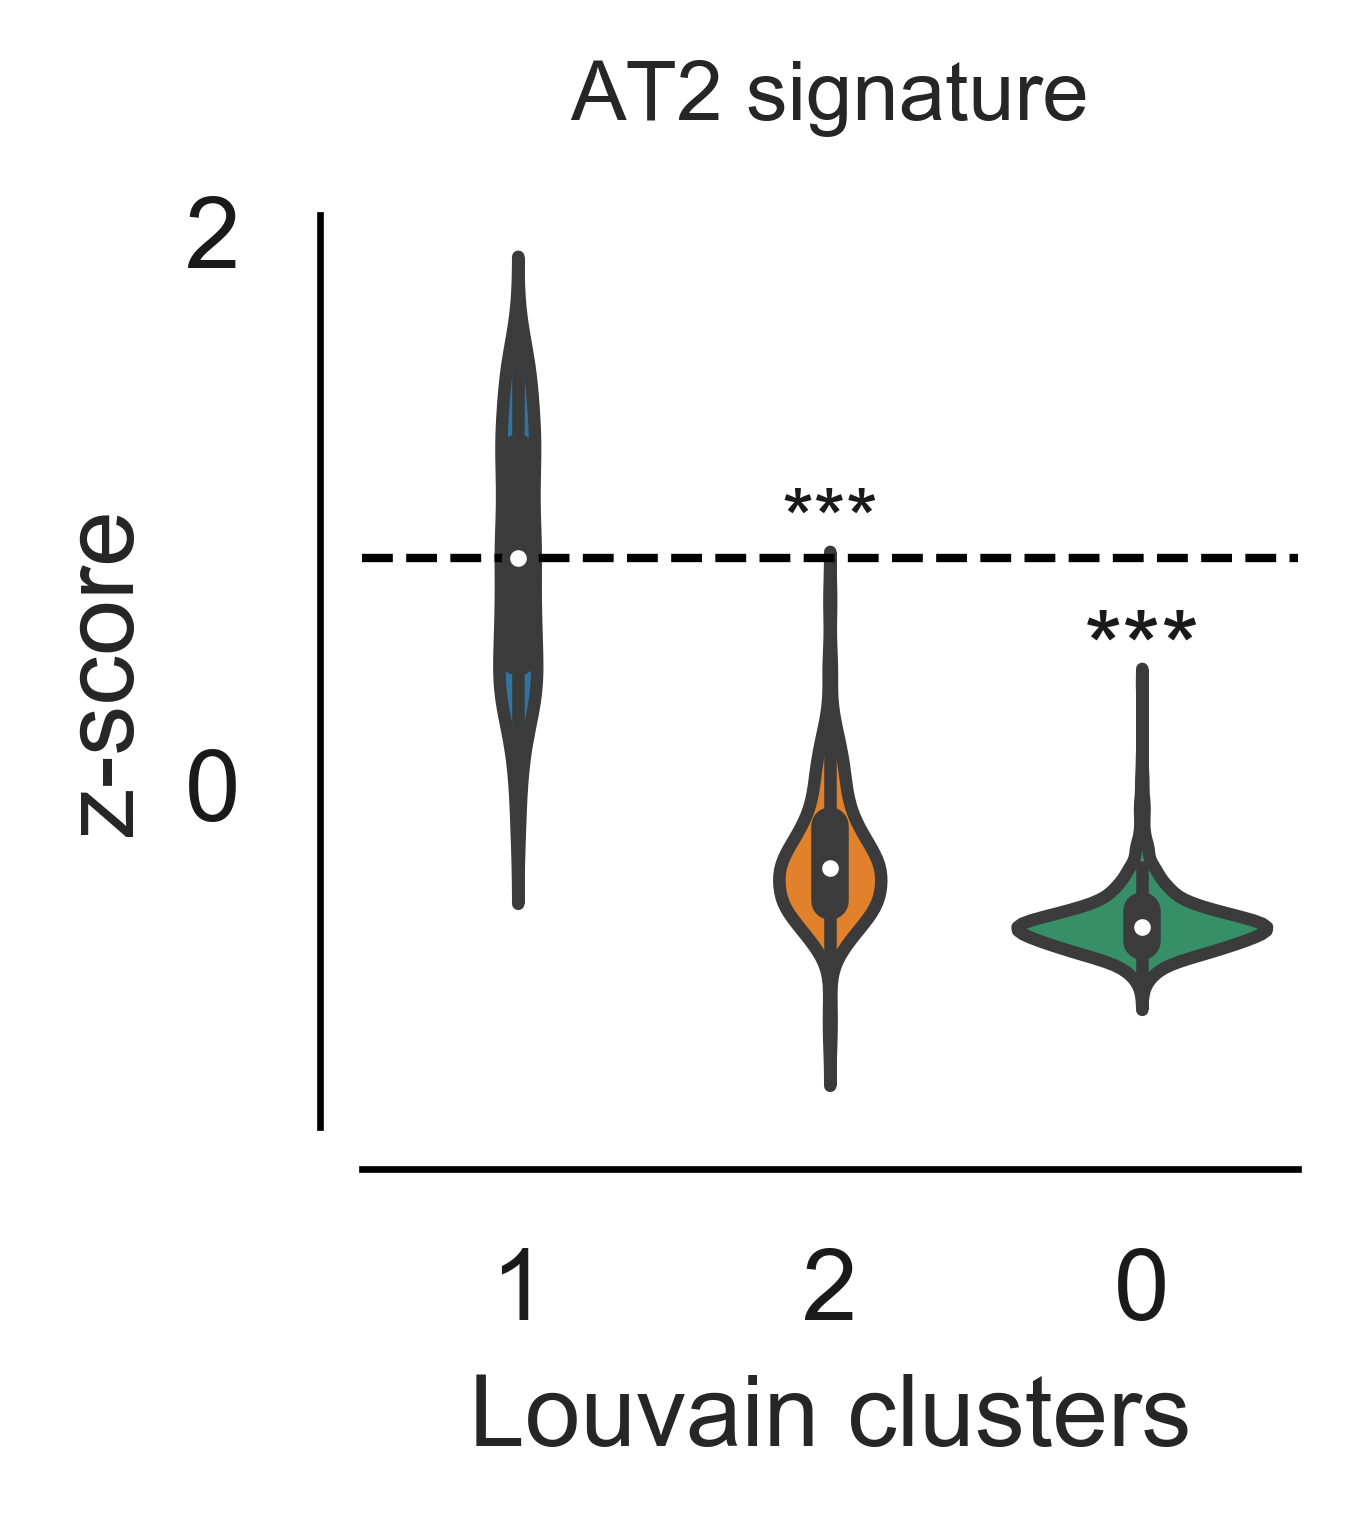

In [367]:
# Plot results
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=300
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='AT2 signature', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'])
despine(right=True, offset=5)
plt.title('AT2 signature', fontsize=10, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.818585, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['AT2 signature'].max() + 0.8, 0.8, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['AT2 signature'].max() + 0.3, 0.3, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/AT2 signature_withstats.png', bbox_inches='tight')

## Plot correlations

### Figure S5B

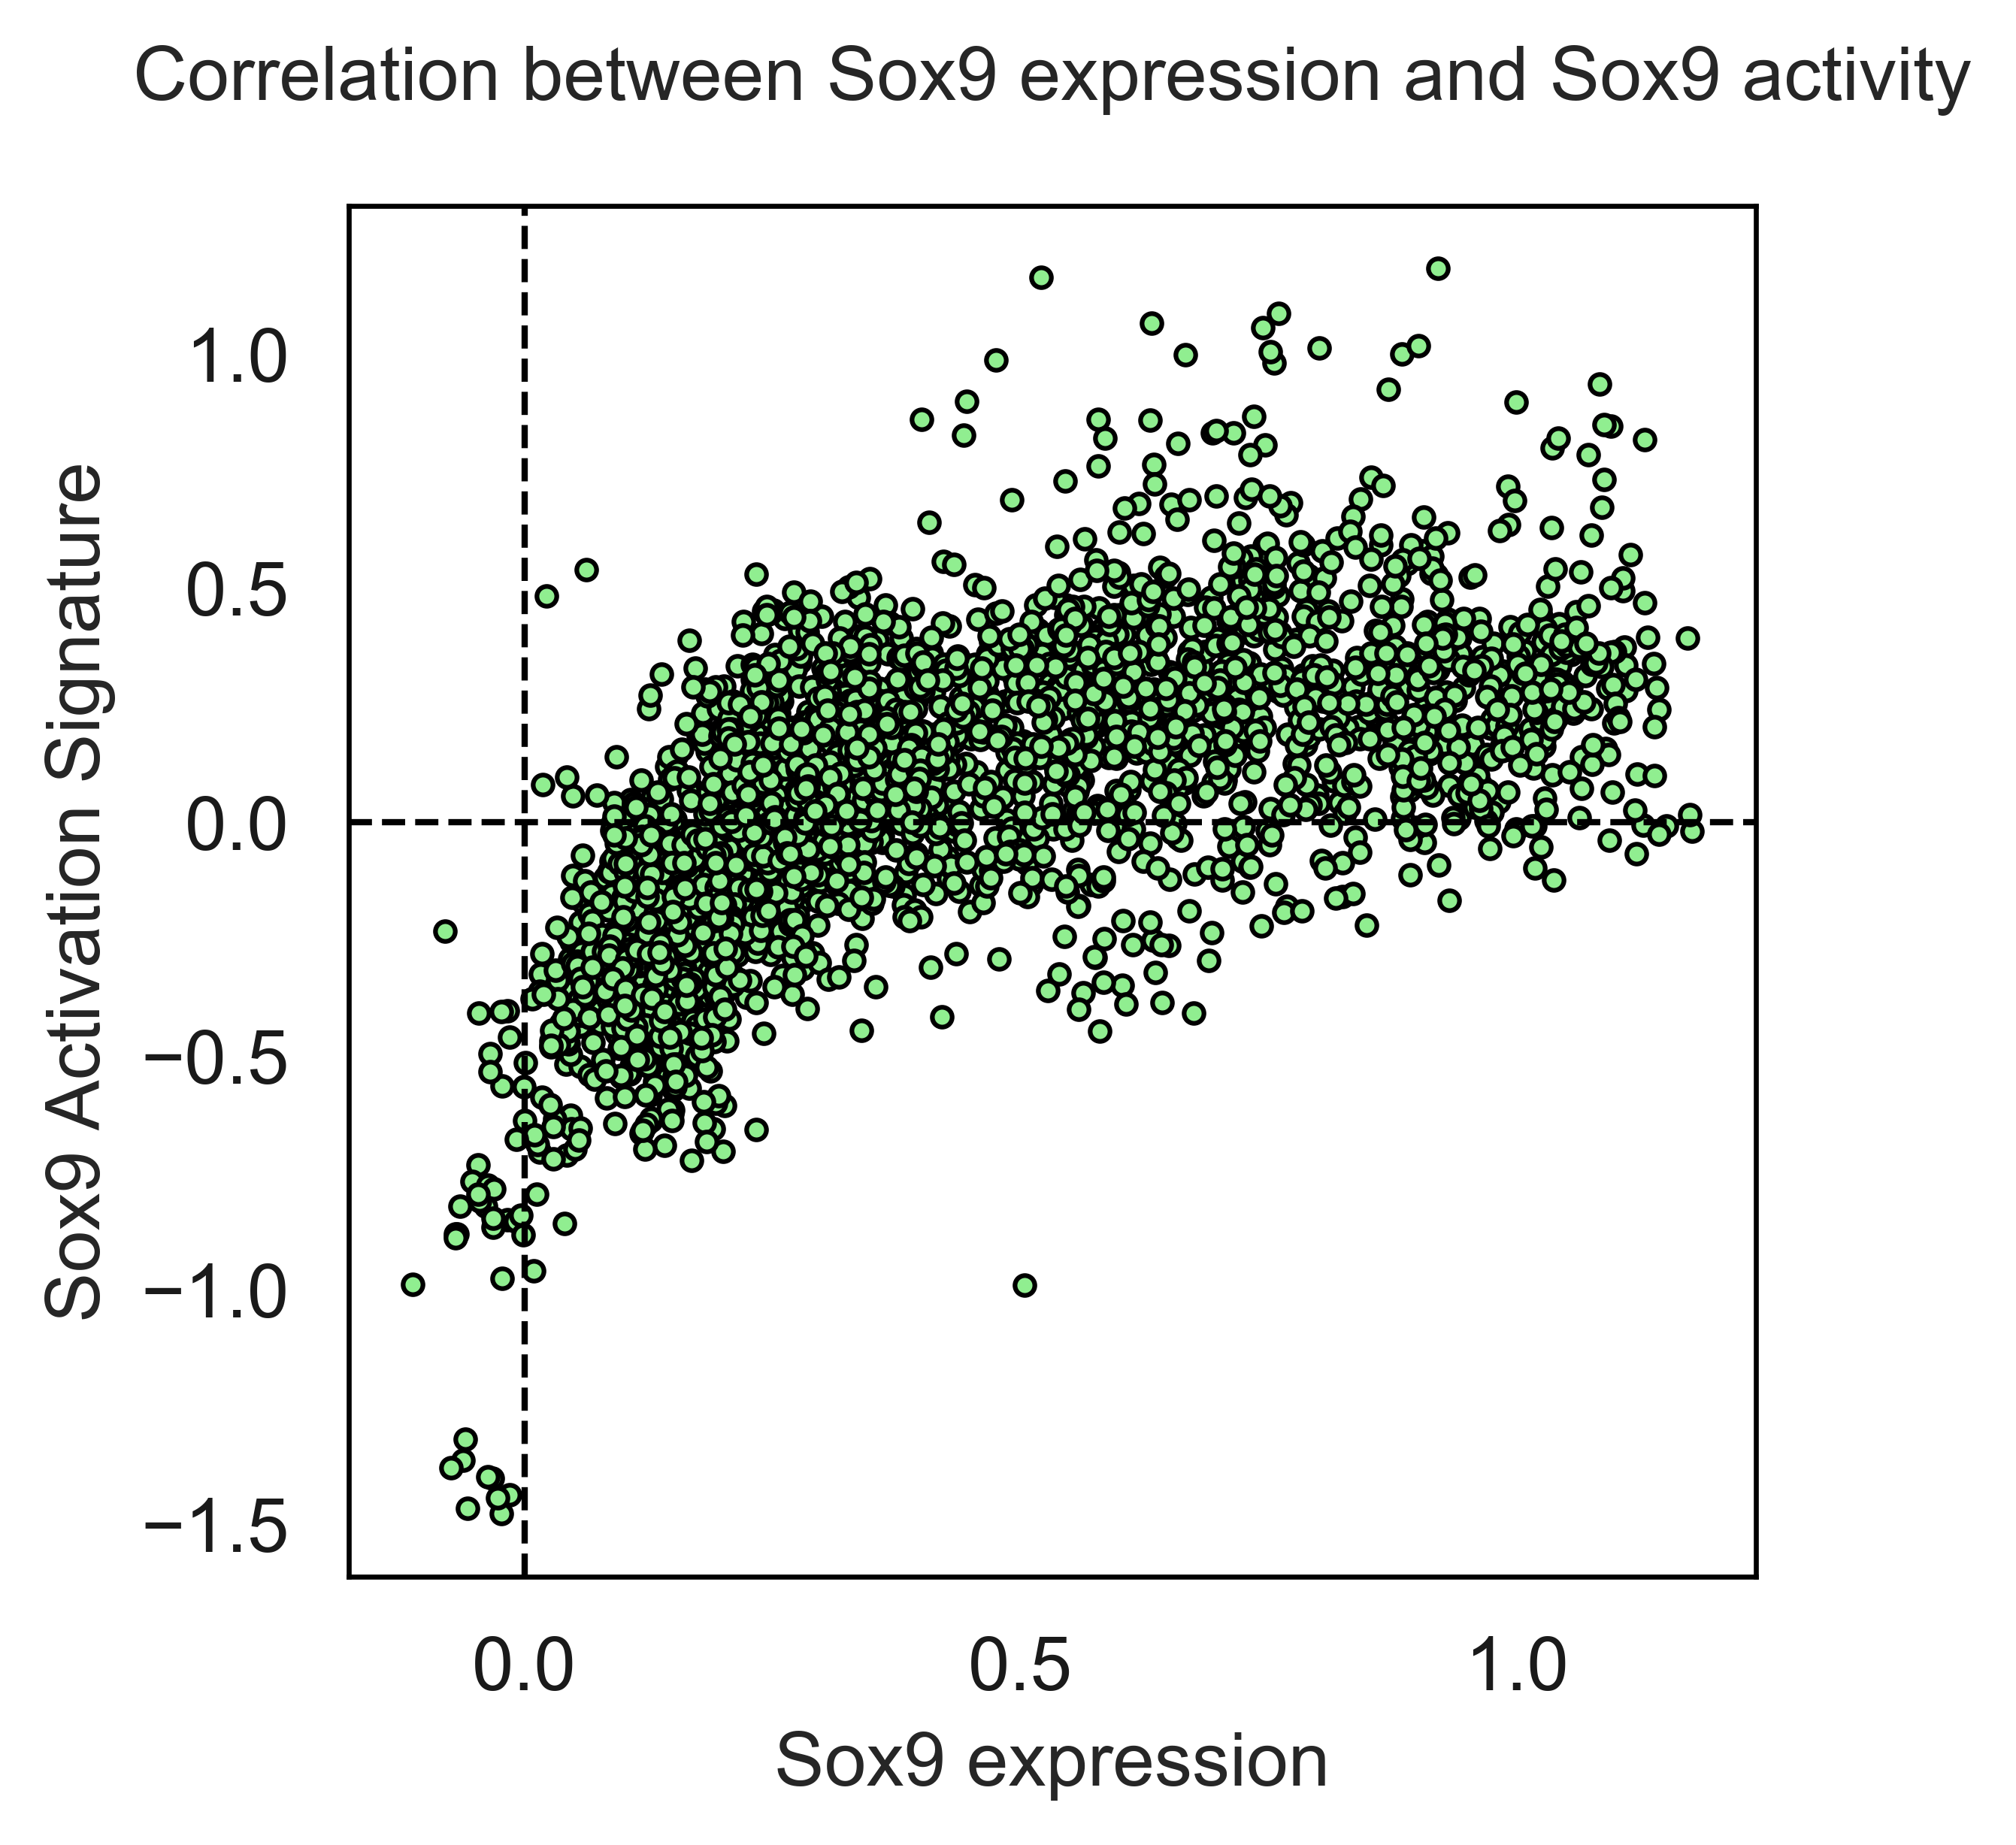

In [630]:
adata_cancer = adata_subset[adata_subset.obs['louvain_r0.2'].isin(['0','2'])]
y=adata_cancer.obs['Sox9_score']
x=adata_cancer.obs['Sox9']
color='lightgreen'
hue=None
legend=False
kwargs={"alpha":1,"s":10,'edgecolor':'black'}

rcParams['figure.figsize'] = 4,4
with axes_style({'axes.grid': False}):
 ax = sb.scatterplot(x=x, y=y, color=color,hue=hue, **kwargs)
plt.title('Correlation between Sox9 expression and Sox9 activity', fontsize=12, y=1.05)
plt.xlabel('Sox9 expression', fontsize=12)
plt.ylabel('Sox9 Activation Signature', fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xticks(fontsize=12, rotation=0)
plt.axhline(0, color='black', linestyle='dashed', linewidth = 1)
plt.axvline(0, color='black', linestyle='dashed', linewidth = 1)
plt.savefig('./figures/sox9_correlation.png',bbox_inches='tight', dpi=300)

## Save the data

In [ ]:
# create a results files
results_file = './write/kras_organoids.h5ad'  
subset_results_file = './write/kras_organoids_subset.h5ad' 

In [631]:
# Save the data
adata.write(results_file)
adata_subset.write(subset_results_file)